In [3]:
'''
Student Names + (IDs): 

Abdelrahman Mohamed Kamal Abdelaziz (1220255)
Mazen Ahmed Fouad Abdelwahab (1220269)
Mohamed Hesham Ibrahim Hassanain (1220278)
Ahmed Walaa Abdlelkhalek Abdelrahman (1220216)

'''
#Import(s)
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
from skimage.feature import canny
from skimage.color import rgb2gray

In [4]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

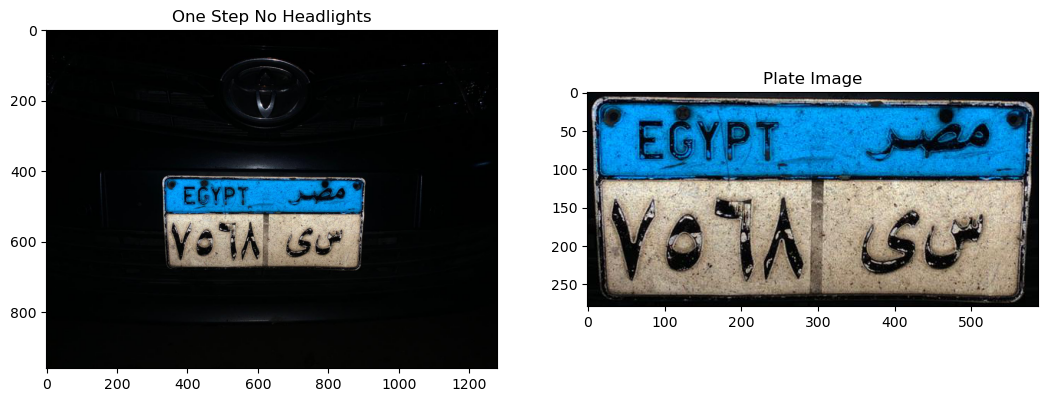

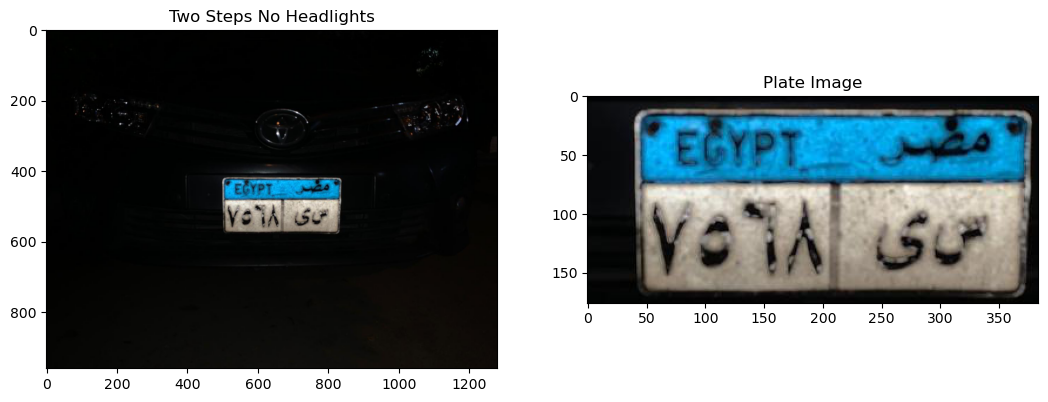

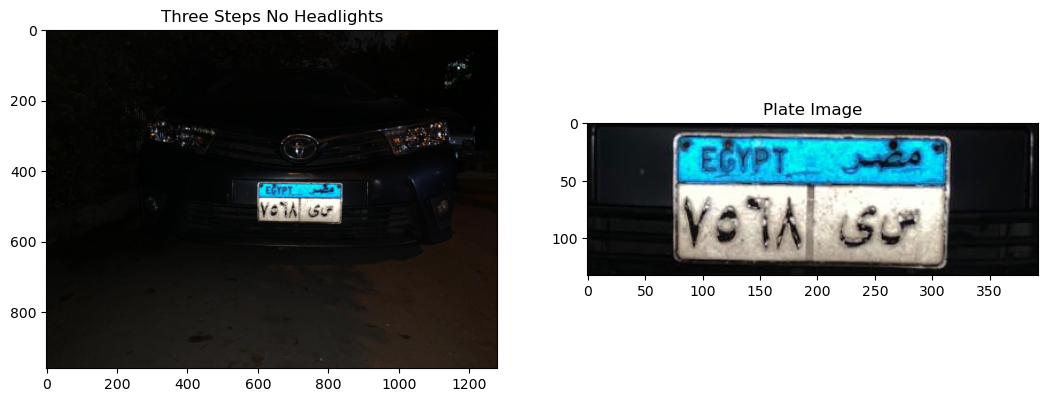

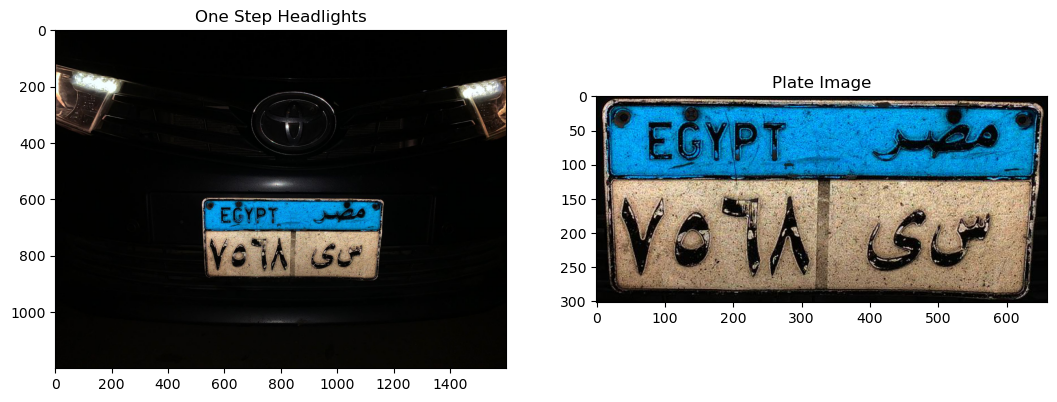

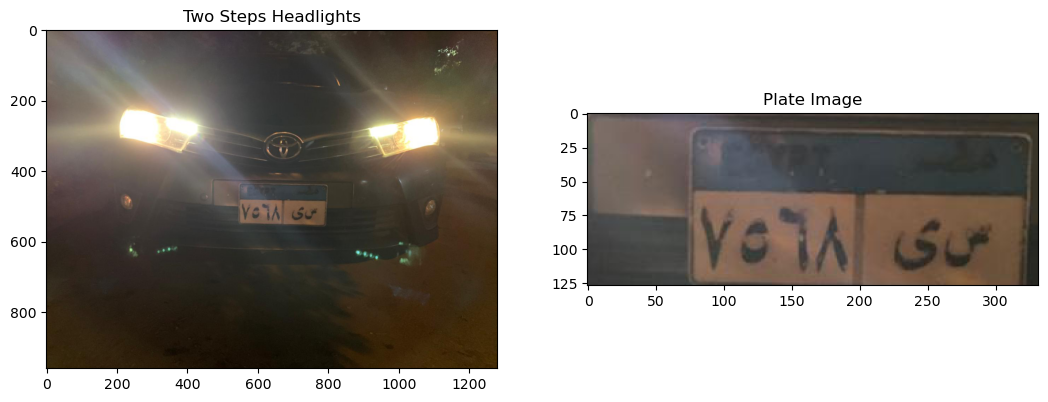

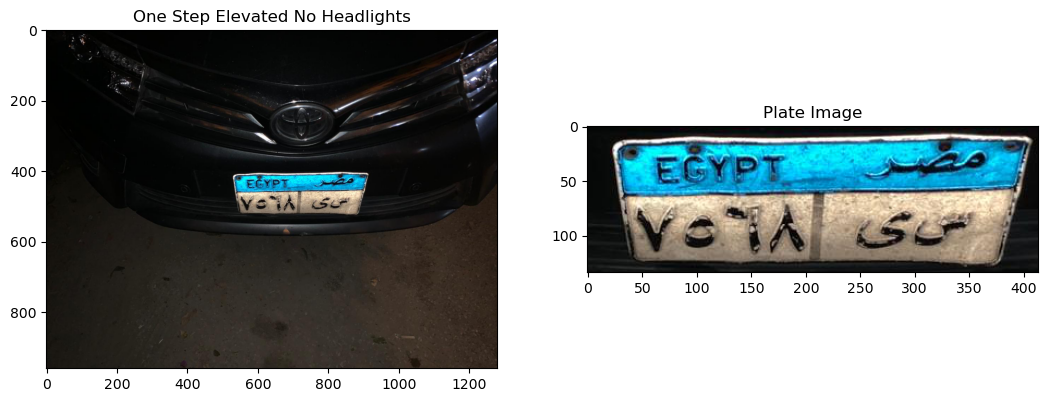

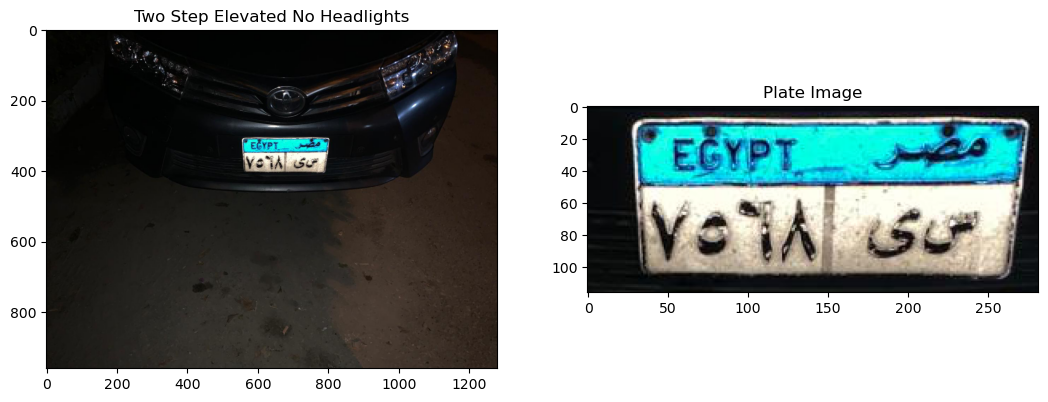

In [ ]:
# Plate Localization

#-------------------------------------------------------------------------------------------------------------------------------

Path1 = 'Localization Test/One Step All Angles No Headlights/Straight.jpeg'
Path2 = 'Localization Test/Two Step All Angles No Headlights/Straight.jpeg'
Path3 = 'Localization Test/Three Step All Angles No Headlights/Straight.jpeg'
Path4 = 'Localization Test/One Step All Angles With Headlights/Straight.jpeg'
Path5 = 'Localization Test/Two Step All Angles With Headlights/Straight.jpeg'

Path11 = 'Localization Test/One Step All Angles No Headlights/Elevated.jpeg'
Path12 = 'Localization Test/Two Step All Angles No Headlights/Elevated.jpeg'
Path13 = 'Localization Test/Three Step All Angles No Headlights/Elevated.jpeg'
Path14 = 'Localization Test/One Step All Angles With Headlights/Elevated.jpeg'
Path15 = 'Localization Test/Two Step All Angles With Headlights/Elevated.jpeg'

Path111 = 'Localization Test/One Step All Angles No Headlights/Slight Right.jpeg'
Path112 = 'Localization Test/Two Step All Angles No Headlights/Slight Right.jpeg'
Path113 = 'Localization Test/Three Step All Angles No Headlights/Slight Right.jpeg'
Path114 = 'Localization Test/One Step All Angles With Headlights/Right.jpeg'
Path115 = 'Localization Test/Two Step All Angles With Headlights/Right.jpeg'

Path1111 = 'Localization Test/One Step All Angles No Headlights/Slight Left.jpeg'
Path1112 = 'Localization Test/Two Step All Angles No Headlights/Slight Left.jpeg'
Path1113 = 'Localization Test/Three Step All Angles No Headlights/Slight Left.jpeg'
Path1114 = 'Localization Test/One Step All Angles With Headlights/Left.jpeg'
Path1115 = 'Localization Test/Two Step All Angles With Headlights/Left.jpeg'

Path11111 = 'Localization Test/One Step All Angles No Headlights/Extreme Left.jpeg'
Path11112 = 'Localization Test/One Step All Angles No Headlights/Extreme Right.jpeg'
Path11113 = 'Localization Test/Two Step All Angles No Headlights/Extreme Left.jpeg'
Path11114 = 'Localization Test/Two Step All Angles No Headlights/Extreme Right.jpeg'
Path11115 = 'Localization Test/Three Step All Angles No Headlights/Extreme Left.jpeg'
Path11116 = 'Localization Test/Three Step All Angles No Headlights/Extreme Right.jpeg'
   
#-------------------------------------------------------------------------------------------------------------------------------

def Plate_Detection(image_path):

    # Original Image
    Original_Img = io.imread(image_path)[:,:,:3]
    Height, Width, _ = Original_Img.shape

    # Read Image and convert to grayscale
    img = cv2.imread(image_path)[:,:,:3]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray)

    # Apply Gaussian Blur to reduce noise
    gray_blur = cv2.GaussianBlur(gray_clahe, (5,5), 0)

    # Adaptive Thresholding to handle dark and bright regions
    thresh = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)

    # Morphological closing to connect fragmented regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plate_candidates = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h
        area_ratio = (w * h) / (Height * Width)
        if (1.8 < aspect_ratio < 3.7) and (0.01 < area_ratio < 0.3):
            plate_candidates.append((x, y, w, h))

    if not plate_candidates:
        print("No plate candidate found.")
        return None

    # Choose the best candidate
    Best_Score = -1
    Best_Candidate = None

    for (x, y, w, h) in plate_candidates:

        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        Current_Image = Original_Img[y:y+h, x:x+w]

        # --- Edge Density ---
        CannyEdges = canny(rgb2gray(Current_Image), sigma=1.0)
        edge_ratio = np.count_nonzero(CannyEdges) / (h * w)

        # --- Color / brightness variance ---
        # use brightness (mean over channels) as a simple measure
        brightness = Current_Image.mean(axis=2)
        brightness_var = np.var(brightness)

        # show_images([Current_Image], [f"Candidate Plate Edge Ratio: {edge_ratio:.4f} , Brightness Var: {brightness_var:.4f}"])

        # --- Combined score ---
        # Edge density is still the main factor, color helps down-weight bad ones
        score = brightness_var

        if score > Best_Score:
            Best_Score = score
            Best_Candidate = (x, y, w, h)


    # Crop the best candidate
    x, y, w, h = Best_Candidate
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show_images([img], ["Best Plate Candidate"])
    plate_img = Original_Img[y:y+h, x:x+w] 
    
    return plate_img

#-------------------------------------------------------------------------------------------------------------------------------
# Testing the Plate Detection Function on Different Images
#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img1 = io.imread(Path1)
Detected_Plate1 = Plate_Detection(Path1)
if Detected_Plate1 is not None:
    show_images([Origignal_Img1, Detected_Plate1], ["One Step No Headlights", "Plate Image"])

Origignal_Img2 = io.imread(Path2)
Detected_Plate2 = Plate_Detection(Path2)
if Detected_Plate2 is not None:
    show_images([Origignal_Img2, Detected_Plate2], ["Two Steps No Headlights", "Plate Image"])

Origignal_Img3 = io.imread(Path3)
Detected_Plate3 = Plate_Detection(Path3)
if Detected_Plate3 is not None:
    show_images([Origignal_Img3, Detected_Plate3], ["Three Steps No Headlights", "Plate Image"])

Origignal_Img4 = io.imread(Path4)
Detected_Plate4 = Plate_Detection(Path4)
if Detected_Plate4 is not None:
    show_images([Origignal_Img4, Detected_Plate4], ["One Step Headlights", "Plate Image"])

Origignal_Img5 = io.imread(Path5)
Detected_Plate5 = Plate_Detection(Path5)
if Detected_Plate5 is not None:
    show_images([Origignal_Img5, Detected_Plate5], ["Two Steps Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img11 = io.imread(Path11)
Detected_Plate11 = Plate_Detection(Path11)
if Detected_Plate11 is not None:
    show_images([Origignal_Img11, Detected_Plate11], ["One Step Elevated No Headlights", "Plate Image"]) 

Origignal_Img12 = io.imread(Path12)
Detected_Plate12 = Plate_Detection(Path12)
if Detected_Plate12 is not None:
    show_images([Origignal_Img12, Detected_Plate12], ["Two Step Elevated No Headlights", "Plate Image"])

Origignal_Img13 = io.imread(Path13)
Detected_Plate13 = Plate_Detection(Path13)
if Detected_Plate13 is not None:
    show_images([Origignal_Img13, Detected_Plate13], ["Three Step Elevated No Headlights", "Plate Image"])

Origignal_Img14 = io.imread(Path14)
Detected_Plate14 = Plate_Detection(Path14) 
if Detected_Plate14 is not None:
    show_images([Origignal_Img14, Detected_Plate14], ["One Step Elevated Headlights", "Plate Image"])

Origignal_Img15 = io.imread(Path15)
Detected_Plate15 = Plate_Detection(Path15)  
if Detected_Plate15 is not None:
    show_images([Origignal_Img15, Detected_Plate15], ["Two Step Elevated Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img111 = io.imread(Path111)
Detected_Plate111 = Plate_Detection(Path111)
if Detected_Plate111 is not None:
    show_images([Origignal_Img111, Detected_Plate111], ["One Step Slight Right No Headlights", "Plate Image"])

Origignal_Img112 = io.imread(Path112)
Detected_Plate112 = Plate_Detection(Path112)
if Detected_Plate112 is not None:
    show_images([Origignal_Img112, Detected_Plate112], ["Two Step Slight Right No Headlights", "Plate Image"])

Origignal_Img113 = io.imread(Path113)
Detected_Plate113 = Plate_Detection(Path113)
if Detected_Plate113 is not None:
    show_images([Origignal_Img113, Detected_Plate113], ["Three Step Slight Right No Headlights", "Plate Image"])

Origignal_Img114 = io.imread(Path114)
Detected_Plate114 = Plate_Detection(Path114)
if Detected_Plate114 is not None:
    show_images([Origignal_Img114, Detected_Plate114], ["One Step Slight Right Headlights", "Plate Image"])

Origignal_Img115 = io.imread(Path115)
Detected_Plate115 = Plate_Detection(Path115)
if Detected_Plate115 is not None:
    show_images([Origignal_Img115, Detected_Plate115], ["Two Step Slight Right Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img1111 = io.imread(Path1111)
Detected_Plate1111 = Plate_Detection(Path1111)
if Detected_Plate1111 is not None:
    show_images([Origignal_Img1111, Detected_Plate1111], ["One Step Slight Left No Headlights", "Plate Image"])

Origignal_Img1112 = io.imread(Path1112)
Detected_Plate1112 = Plate_Detection(Path1112)
if Detected_Plate1112 is not None:
    show_images([Origignal_Img1112, Detected_Plate1112], ["Two Step Slight Left No Headlights", "Plate Image"])

Origignal_Img1113 = io.imread(Path1113)
Detected_Plate1113 = Plate_Detection(Path1113)
if Detected_Plate1113 is not None:
    show_images([Origignal_Img1113, Detected_Plate1113], ["Three Step Slight Left No Headlights", "Plate Image"])

Origignal_Img1114 = io.imread(Path1114)
Detected_Plate1114 = Plate_Detection(Path1114)
if Detected_Plate1114 is not None:
    show_images([Origignal_Img1114, Detected_Plate1114], ["One Step Slight Left Headlights", "Plate Image"])

Origignal_Img1115 = io.imread(Path1115)
Detected_Plate1115 = Plate_Detection(Path1115)
if Detected_Plate1115 is not None:
    show_images([Origignal_Img1115, Detected_Plate1115], ["Two Step Slight Left Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Original_Img11111 = io.imread(Path11111)
Detected_Plate11111 = Plate_Detection(Path11111)
if Detected_Plate11111 is not None:
    show_images([Original_Img11111, Detected_Plate11111], ["One Step Extreme Left No Headlights", "Plate Image"])

Original_Img11112 = io.imread(Path11112)
Detected_Plate11112 = Plate_Detection(Path11112)
if Detected_Plate11112 is not None:
    show_images([Original_Img11112, Detected_Plate11112], ["One Step Extreme Right No Headlights", "Plate Image"])

Original_Img11113 = io.imread(Path11113)
Detected_Plate11113 = Plate_Detection(Path11113)
if Detected_Plate11113 is not None:
    show_images([Original_Img11113, Detected_Plate11113], ["Two Step Extreme Left No Headlights", "Plate Image"])

Original_Img11114 = io.imread(Path11114)
Detected_Plate11114 = Plate_Detection(Path11114)
if Detected_Plate11114 is not None:
    show_images([Original_Img11114, Detected_Plate11114], ["Two Step Extreme Right No Headlights", "Plate Image"])

Original_Img11115 = io.imread(Path11115)
Detected_Plate11115 = Plate_Detection(Path11115)
if Detected_Plate11115 is not None:
    show_images([Original_Img11115, Detected_Plate11115], ["Three Step Extreme Left No Headlights", "Plate Image"])

Original_Img11116 = io.imread(Path11116)
Detected_Plate11116 = Plate_Detection(Path11116)
if Detected_Plate11116 is not None:
    show_images([Original_Img11116, Detected_Plate11116], ["Three Step Extreme Right No Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Original_Img11117 = io.imread('trella.png')[:,:,:3]
Detected_Plate11117 = Plate_Detection('trella.png')
if Detected_Plate11117 is not None:
    show_images([Original_Img11117, Detected_Plate11117], ["Trella", "Plate Image"])

# import os

# BASE_PATH = "Localization Test/Vehicles"

# START_ID = 1
# END_ID   = 2087

# for i in range(START_ID, END_ID + 1):
#     fname = f"{i:04d}.jpg"        # 0001.jpg, 0002.jpg, ...
#     fpath = os.path.join(BASE_PATH, fname)

#     if not os.path.exists(fpath):
#         print(f"[SKIP] Missing: {fpath}")
#         continue

#     try:
#         img = io.imread(fpath)    # RGB (as you want)
#         title = f"Vehicle_{fname}"
#         print(f"[RUN] {title}")
#         Detected_Plate11116=Plate_Detection(fpath)
#         if Detected_Plate11116 is not None:
#             show_images([img, Detected_Plate11116], ["img", "detect"])

#     except Exception as e:
#         print(f"[ERROR] {fname}: {e}")

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ================================================================
#  DEBUG VIEW
# ================================================================
def _show_mask_debug(mask, title):
    plt.figure(figsize=(4, 2))
    plt.imshow(mask, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ======================================================================
#  HELPER: draw candidate rectangles on debug image
# ======================================================================
def draw_candidates_debug(img, candidates, best_idx):
    debug_img = img.copy()

    for i, c in enumerate(candidates):
        color = (0,255,0) if i==best_idx else \
                (random.randint(50,255), random.randint(50,255), random.randint(50,255))

        x0, y0, x1, y1 = c["x0"], c["y0"], c["x1"], c["y1"]
        cv2.rectangle(debug_img, (x0,y0), (x1,y1), color, 2)
        cv2.putText(debug_img, f"{c['score']:.2f}", (x0, y0-4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return debug_img


# ================================================================
#  TIERS
# ================================================================
BLUE_PARAMS_STRICT = dict(BLUE_SAT_THRESH=140, BLUE_VAL_THRESH=110, BLUE_HUE_MIN=80, BLUE_HUE_MAX=120, BLUE_DELTA=12)
BLUE_PARAMS_MID    = dict(BLUE_SAT_THRESH=115, BLUE_VAL_THRESH=95,  BLUE_HUE_MIN=80, BLUE_HUE_MAX=120, BLUE_DELTA=14)
BLUE_PARAMS_LENIENT= dict(BLUE_SAT_THRESH=60,  BLUE_VAL_THRESH=80,  BLUE_HUE_MIN=75, BLUE_HUE_MAX=125, BLUE_DELTA=18)
BLUE_PARAMS_VERY_LENIENT = dict(BLUE_SAT_THRESH=30, BLUE_VAL_THRESH=60, BLUE_HUE_MIN=70, BLUE_HUE_MAX=135, BLUE_DELTA=22)

BLUE_PARAMS_ULTRA_LENIENT = dict(
    BLUE_SAT_THRESH=18,
    BLUE_VAL_THRESH=45,
    BLUE_HUE_MIN=65,
    BLUE_HUE_MAX=145,
    BLUE_DELTA=26
)

BLUE_PARAMS_MAX_LENIENT = dict(
    BLUE_SAT_THRESH=8,
    BLUE_VAL_THRESH=35,
    BLUE_HUE_MIN=55,
    BLUE_HUE_MAX=160,
    BLUE_DELTA=32
)

BLUE_PARAMS_NUCLEAR = dict(
    BLUE_SAT_THRESH = 3,
    BLUE_VAL_THRESH = 25,
    BLUE_HUE_MIN    = 45,
    BLUE_HUE_MAX    = 170,
    BLUE_DELTA      = 40
)

BLUE_PARAM_TIERS = [
    ("STRICT",       BLUE_PARAMS_STRICT),
    ("MID",          BLUE_PARAMS_MID),
    ("LENIENT",      BLUE_PARAMS_LENIENT),
    ("VERY_LENIENT", BLUE_PARAMS_VERY_LENIENT),
    ("ULTRA_LENIENT", BLUE_PARAMS_ULTRA_LENIENT),
    ("MAX_LENIENT",   BLUE_PARAMS_MAX_LENIENT),
    ("NUCLEAR",       BLUE_PARAMS_NUCLEAR),
]

TIER_BONUS = {
    "STRICT": 0.18,
    "MID": 0.12,
    "LENIENT": 0.06,
    "VERY_LENIENT": 0.00,
    "ULTRA_LENIENT": -0.06,
    "MAX_LENIENT":   -0.10,
    "NUCLEAR":       -0.10,
}

# ================================================================
#  SCORING HYPERPARAMS
# ================================================================
HUE_CENTER = 100
HUE_SIGMA  = 18.0

WHITE_S_MAX = 90
WHITE_V_MIN = 120

W_CC_DOM   = 0.22
W_ROW_BAND = 0.18
W_BLUE     = 0.26
W_SAT      = 0.10
W_BELOW    = 0.18
W_TOP_PRIOR= 0.06


# ================================================================
def _adaptive_blue_mask_with_params(img_rgb, params, debug=False, tag=""):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)

    sat_thr = params["BLUE_SAT_THRESH"]
    val_thr = params["BLUE_VAL_THRESH"]
    hue_min = params["BLUE_HUE_MIN"]
    hue_max = params["BLUE_HUE_MAX"]
    delta   = params["BLUE_DELTA"]

    colored = (S > sat_thr) & (V > val_thr)
    H_colored = H[colored]

    hue_mask = (H_colored >= hue_min) & (H_colored <= hue_max)
    blue_hues = H_colored[hue_mask]

    if blue_hues.size == 0:
        if debug:
            print(f"[{tag}] No blue hues found in candidate window.")
        return np.zeros_like(H, dtype=np.uint8), None, None

    hist, bin_edges = np.histogram(blue_hues, bins=36, range=(0, 180))
    peak_bin = int(np.argmax(hist))
    h_peak = 0.5 * (bin_edges[peak_bin] + bin_edges[peak_bin + 1])

    h_low  = max(0,   int(h_peak - delta))
    h_high = min(179, int(h_peak + delta))

    lower_blue = np.array([h_low,  sat_thr, val_thr], dtype=np.uint8)
    upper_blue = np.array([h_high, 255,     255],     dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    if debug:
        n = int(mask.sum() // 255)
        print(f"[{tag}] Peak={h_peak:.1f}, H=({h_low},{h_high}), S>{sat_thr}, V>{val_thr}, pixels={n}")

    return mask, lower_blue, upper_blue


def _hue_distance_circular(h, center):
    d = np.abs(h.astype(np.float32) - float(center))
    return np.minimum(d, 180.0 - d)


def _score_component(mask, hsv, comp_mask, bbox, tier_name, debug=False):
    Himg, Wimg = mask.shape[:2]
    x, y, w, h = bbox
    area = float(comp_mask.sum())
    total = float((mask > 0).sum()) + 1e-6

    cc_dom = area / total

    y_center = y + 0.5*h
    top_prior = 1.0 - np.clip(y_center / (0.65 * Himg + 1e-6), 0.0, 1.0)

    sub = mask[y:y+h, x:x+w] > 0
    if sub.size == 0:
        return -1e9, {}
    row_counts = sub.sum(axis=1).astype(np.float32)
    if row_counts.max() <= 0:
        row_band = 0.0
    else:
        peak = row_counts.max()
        mean = row_counts.mean() + 1e-6
        peakiness = float(peak / mean)
        thr = 0.6 * peak
        strong = row_counts >= thr
        longest = 0
        cur = 0
        for v in strong:
            if v:
                cur += 1
                longest = max(longest, cur)
            else:
                cur = 0
        run_frac = float(longest / (h + 1e-6))
        row_band = np.tanh((peakiness - 1.5) / 2.0) * 0.6 + run_frac * 0.4
        row_band = float(np.clip(row_band, 0.0, 1.0))

    Hc = hsv[...,0][comp_mask]
    Sc = hsv[...,1][comp_mask]
    if Hc.size == 0:
        blue_score = 0.0
        sat_score  = 0.0
    else:
        d = _hue_distance_circular(Hc, HUE_CENTER)
        mean_d = float(d.mean())
        blue_score = float(np.exp(- (mean_d**2) / (2.0 * (HUE_SIGMA**2))))
        sat_score = float(np.clip(Sc.mean() / 255.0, 0.0, 1.0))

    y0 = int(y + h)
    y1 = int(min(Himg, y + h + 1.5*h))
    if y1 <= y0 + 2:
        below_white = 0.0
    else:
        below = hsv[y0:y1, x:x+w]
        S_b = below[...,1].astype(np.uint8)
        V_b = below[...,2].astype(np.uint8)
        white = (S_b < WHITE_S_MAX) & (V_b > WHITE_V_MIN)
        below_white = float(white.mean())

    tier_bonus = TIER_BONUS.get(tier_name, 0.0)

    score = (
        W_CC_DOM    * cc_dom +
        W_ROW_BAND  * row_band +
        W_BLUE      * blue_score +
        W_SAT       * sat_score +
        W_BELOW     * below_white +
        W_TOP_PRIOR * top_prior +
        tier_bonus
    )

    if debug:
        print(f"    [{tier_name}] bbox={x,y,w,h} "
              f"score={score:.3f} | cc={cc_dom:.2f} row={row_band:.2f} blue={blue_score:.2f} "
              f"sat={sat_score:.2f} belowW={below_white:.2f} top={top_prior:.2f} +bonus={tier_bonus:.2f}")

    return float(score), dict(bbox=(x,y,w,h))


def adaptive_blue_mask(img_rgb, debug=False):
    # NOTE: keep everything minimal
    Himg, Wimg = img_rgb.shape[:2]

    # ------------------------------------------------------------
    # NEW: probe STRICT + MID, and if both are "near empty", rescue
    # ------------------------------------------------------------
    RESCUE_WHITE_THR = 200  # you can tune this
    did_rescue = False

    # quick probe on ORIGINAL img
    maskS, _, _ = _adaptive_blue_mask_with_params(img_rgb, BLUE_PARAMS_STRICT, debug=False, tag="PROBE_STRICT")
    maskM, _, _ = _adaptive_blue_mask_with_params(img_rgb, BLUE_PARAMS_MID,    debug=False, tag="PROBE_MID")

    nS = int(maskS.sum() // 255) if maskS is not None else 0
    nM = int(maskM.sum() // 255) if maskM is not None else 0

    img_work = img_rgb

    if (nS < RESCUE_WHITE_THR) and (nM < RESCUE_WHITE_THR):
        did_rescue = True
        if debug:
            print(f"[RESCUE TRIGGER] STRICT={nS} MID={nM} < {RESCUE_WHITE_THR} -> calling rescue_blue_strip_rgb_extreme()")

        img_rescued = rescue_blue_strip_rgb_extreme(img_rgb, debug=True)

        if debug:
            # show before/after so you see what happened
            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1); plt.imshow(img_rgb);     plt.title("Original (before rescue)"); plt.axis("off")
            plt.subplot(1,2,2); plt.imshow(img_rescued); plt.title("After rescue_blue_strip_rgb_extreme"); plt.axis("off")
            plt.tight_layout()
            plt.show()

        # reset pipeline on rescued image
        img_work = img_rescued

    # now proceed normally, BUT using img_work (original or rescued)
    hsv = cv2.cvtColor(img_work, cv2.COLOR_RGB2HSV)

    best = dict(score=-1e9, mask=None, lb=None, ub=None, tier=None, bbox=None, did_rescue=did_rescue)

    for tier_name, params in BLUE_PARAM_TIERS:
        mask, lb, ub = _adaptive_blue_mask_with_params(img_work, params, debug=debug, tag=tier_name)

        # keep your dilation exactly as-is
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)), iterations=1)

        if debug:
            _show_mask_debug(mask, f"{tier_name} mask (raw+dilated)")

        if lb is None or mask.sum() == 0:
            continue

        bin_mask = (mask > 0).astype(np.uint8)
        num, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)

        for comp_id in range(1, num):
            x, y, w, h, area = stats[comp_id]
            if area < 20:
                continue

            comp_mask = (labels == comp_id)
            score, details = _score_component(mask, hsv, comp_mask, (x,y,w,h), tier_name, debug=debug)

            if score > best["score"]:
                best.update(score=score, mask=mask, lb=lb, ub=ub, tier=tier_name, bbox=(x,y,w,h))

    if best["mask"] is None:
        return np.zeros((Himg, Wimg), dtype=np.uint8), None, None, None, None

    if debug:
        x,y,w,h = best["bbox"]
        print(f"\n✅ CHOSEN OVERALL: tier={best['tier']} score={best['score']:.3f} bbox={(x,y,w,h)} rescue_used={did_rescue}\n")

    return best["mask"], best["lb"], best["ub"], best["tier"], best["bbox"]


#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def crop_left_right_by_blue_adaptive(img_bgr, debug=False):
    H, W = img_bgr.shape[:2]

    mask, lb, ub, tier, bbox = adaptive_blue_mask(img_bgr, debug)

    if debug:
        print("✅ Tier used:", tier)

    if lb is None:
        if debug:
            print("❌ No blue detected")
        return None, None, mask, None

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_RGB2HSV)

    row_counts = mask.sum(axis=1)//255
    max_row = row_counts.max()
    if max_row == 0:
        return None, None, mask, None

    row_thresh = 0.30*max_row
    blue_rows = row_counts > row_thresh

    bands = []
    cur_start = None
    for y, flag in enumerate(blue_rows):
        if flag and cur_start is None:
            cur_start = y
        elif not flag and cur_start is not None:
            bands.append((cur_start, y))
            cur_start = None
    if cur_start is not None:
        bands.append((cur_start, len(blue_rows)))

    # =====================================================
    # ✅ NEW: two-pass gating thresholds (only used for filtering)
    # =====================================================
    PASS1_MIN_BAND_H_FRAC = 0.02   # your current value
    PASS1_MIN_BAND_W_FRAC = 0.10   # your current value

    PASS2_MIN_BAND_H_FRAC = 0.008  # lenient fallback (far plates)
    PASS2_MIN_BAND_W_FRAC = 0.05   # lenient fallback (far plates)

    # =====================================================
    # ✅ NEW: minimal helper to keep your code unchanged
    # =====================================================
    def _collect_candidates(min_band_h_frac, min_band_w_frac):
        candidates = []

        for (y0_band, y1_band) in bands:
            band_h = y1_band - y0_band
            if band_h < min_band_h_frac * H:
                continue

            submask = mask[y0_band:y1_band, :]

            ys2, xs2 = np.where(submask > 0)
            if xs2.size == 0:
                continue

            # take robust span (ignore tiny outliers)
            x0_band = int(np.percentile(xs2, 1))
            x1_band = int(np.percentile(xs2, 99))
            band_w  = x1_band - x0_band

            # sanity on width relative to whole image
            if band_w < min_band_w_frac * W or band_w > 0.95 * W:
                continue

            # ---- 1) aspect ratio of blue band (smooth) ----
            ar_band = band_w / (band_h + 1e-6)
            s_ar_band = np.tanh((ar_band - 2.0) / 2.0)
            s_ar_band = float(np.clip(s_ar_band, 0.0, 1.0))

            region_hsv = hsv[:, x0_band:x1_band]
            _, Sc, Vc = cv2.split(region_hsv)

            S_MAX = 130
            V_MIN = 80
            white_mask = (Sc < S_MAX) & (Vc > V_MIN)
            white_ratio = float(white_mask.mean())

            s_white = white_ratio

            k = 3.0
            y0_pl = max(0,   int(y0_band - 0.2*band_h))
            y1_pl = min(H-1, int(y0_band + k*band_h))
            plate_h = y1_pl - y0_pl
            ar_plate = band_w / (plate_h + 1e-6)

            expected_ar = 2.0
            sigma = 0.8
            s_ar_plate = float(np.exp(-((ar_plate - expected_ar)**2) / (2 * sigma**2)))

            score = (
                0.20*s_ar_band +
                0.50*s_white   +
                0.30*s_ar_plate
            )

            candidates.append({
                "x0": x0_band, "y0": y0_band,
                "x1": x1_band, "y1": y1_band,
                "width": band_w,
                "height": band_h,
                "score": float(score),
                "white_ratio": white_ratio,
                "s_white": s_white,
                "s_ar_band": s_ar_band,
                "s_ar_plate": s_ar_plate
            })

        return candidates

    # =====================================================
    # ✅ NEW: Pass 1 (original strict gates)
    # =====================================================
    candidates = _collect_candidates(PASS1_MIN_BAND_H_FRAC, PASS1_MIN_BAND_W_FRAC)

    # =====================================================
    # ✅ NEW: Pass 2 ONLY if Pass 1 found nothing
    # =====================================================
    if not candidates:
        candidates = _collect_candidates(PASS2_MIN_BAND_H_FRAC, PASS2_MIN_BAND_W_FRAC)
        if debug and candidates:
            print("[2-PASS] Pass1 empty -> using lenient gates for far/small plate case")

    if not candidates:
        return img_bgr, (0,0,W-1,H-1), mask, img_bgr

    candidates_sorted = sorted(
        candidates,
        key=lambda c: (c["score"], c["white_ratio"], c["width"], c["height"]),
        reverse=True
    )

    best = candidates_sorted[0]
    best_idx = candidates.index(best)

    margin = int(0.02*W)
    x0 = max(0, best["x0"] - margin)
    x1 = min(W-1, best["x1"] + margin)

    y_strip_top = int(best["y0"])
    strip_h     = int(best["height"])

    plate_h = int(3.5 * strip_h)

    y_top = max(0, y_strip_top)

    y_bottom = y_top + plate_h + int(0.10 * strip_h)
    y_bottom = min(H - 1, y_bottom)

    cropped = img_bgr[y_top:y_bottom+1, x0:x1]

    debug_img = draw_candidates_debug(img_bgr, candidates, best_idx)

    if debug:
        print("\n========= CANDIDATE BREAKDOWN =========")
        for i, c in enumerate(candidates):
            print(f"[{i}] score={c['score']:.3f}, "
                  f"white_ratio={c['white_ratio']:.3f}, "
                  f"s_white={c['s_white']:.2f}, "
                  f"ARband={c['s_ar_band']:.2f}, "
                  f"ARplate={c['s_ar_plate']:.2f}, "
                  f"range=({c['x0']},{c['x1']}) "
                  f"vertical=({c['y0']},{c['y1']})")
        print("Chosen:", best)
        print("========================================\n")

    return cropped, (best["x0"], best["y0"], best["x1"], best["y1"]), mask, debug_img



def debug_blue_crop(plate_img, title):
    if plate_img is None:
        print(f"{title}: plate_img is None, skipping.")
        return None

    cropped, bbox, mask, debug_img = crop_left_right_by_blue_adaptive(plate_img, debug=False)

    images = [plate_img]
    titles = [f"{title} - Original"]

    if mask is not None:
        images.append(mask)
        titles.append("Blue mask")

    if debug_img is not None:
        images.append(debug_img)
        titles.append("All candidates")
    else:
        print(f"{title}: debug_img is None (likely no candidates / no blue).")

    if cropped is not None:
        images.append(cropped)
        titles.append("Final crop")
    else:
        print(f"{title}: cropped is None (no blue detected).")

    show_images(images, titles)
    return cropped

def _rotate_keep_all_rgb(img_rgb, angle_deg):
    H, W = img_rgb.shape[:2]
    center = (W * 0.5, H * 0.5)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)

    cos = abs(M[0, 0])
    sin = abs(M[0, 1])
    newW = int(H * sin + W * cos)
    newH = int(H * cos + W * sin)

    M[0, 2] += (newW / 2) - center[0]
    M[1, 2] += (newH / 2) - center[1]

    rot = cv2.warpAffine(
        img_rgb, M, (newW, newH),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE
    )
    return rot


def rescue_blue_strip_rgb_extreme(img_rgb, debug=False):

    """
    MUCH harsher rescue:
      - normalize + CLAHE + stronger gamma on V
      - build a better seed (prefers blue-ish + horizontal band)
      - inside seed: PUSH S/V strongly toward target (S~100, V~90+)
      - optional stronger hue pull toward blue center
    """

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV).astype(np.float32)
    H = hsv[..., 0]
    S = hsv[..., 1]
    V = hsv[..., 2]

    # -----------------------------
    # (1) Robust normalize V (stronger)
    # -----------------------------
    v1 = np.percentile(V, 1)
    v2 = np.percentile(V, 99)
    if v2 > v1 + 1e-3:
        Vn = (V - v1) * (255.0 / (v2 - v1))
        Vn = np.clip(Vn, 0, 255)
    else:
        Vn = V.copy()

    # -----------------------------
    # (2) CLAHE on V (stronger)
    # -----------------------------
    V8 = Vn.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(5, 5))
    Vc = clahe.apply(V8).astype(np.float32)

    # -----------------------------
    # (3) Gamma brighten (more aggressive)
    # gamma < 1 brightens shadows a lot
    # -----------------------------
    gamma = 0.3   # was 0.65, now harsher
    Vg = 255.0 * np.power(np.clip(Vc / 255.0, 0, 1), gamma)

    # slight extra lift to midtones
    Vg = np.clip(Vg + 10.0, 0, 255)

    hsv2 = hsv.copy()
    hsv2[..., 2] = Vg

    # -----------------------------
    # (4) Build a better seed:
    #     - still lenient hue window
    #     - require *some* saturation after V rescue
    #     - favor horizontal structures (blue strip is a long band)
    # -----------------------------
    hsv2_u8 = hsv2.astype(np.uint8)



    lower_seed = np.array([70,  0,  0], dtype=np.uint8)
    upper_seed = np.array([135, 255, 255], dtype=np.uint8)
    seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)



    # lower_seed = np.array([45,  0,  10], dtype=np.uint8)
    # upper_seed = np.array([170, 255, 255], dtype=np.uint8)
    # seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)

    # enforce "not totally gray" AFTER brightening
    # (this rejects lots of glare/white that becomes bright)
    S_min_after = 15
    seed0 = seed0 & ((hsv2_u8[...,1] >= S_min_after).astype(np.uint8) * 255)

    # cleanup
    seed0 = cv2.medianBlur(seed0, 5)

    # horizontal emphasis: open with long horizontal kernel
    seed1 = cv2.morphologyEx(
        seed0, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3)),
        iterations=1
    )

    # connect horizontally
    seed1 = cv2.morphologyEx(
        seed1, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5)),
        iterations=1
    )

    seed01 = (seed1 > 0)

    # -----------------------------
    # (5) EXTREME push of S/V inside seed
    # target-ish: S ~ 95-100, V ~ 80-100
    # -----------------------------
    S2 = S.copy()
    V2 = Vg.copy()

    # Push S upward HARD:
    #   - If S is tiny, multiplication does nothing, so we also ADD a lot
    S2[seed01] = np.clip(S2[seed01] * 2.8 + 80, 0, 255)

    # Push V upward HARD (but still capped):
    V2[seed01] = np.clip(V2[seed01] * 1.35 + 35, 0, 255)

    # Optional: clamp seed area to minimum "good" S/V
    # (forces your desired style)
    S2[seed01] = np.maximum(S2[seed01], 255)   # ~90% of 255
    V2[seed01] = np.maximum(V2[seed01], 230)   # ~75% of 255

    # -----------------------------
    # (6) Stronger hue pull toward blue center
    # -----------------------------
    H2 = H.copy()
    blue_center = 100.0
    pull = 0.55   # was 0.25, now harsher

    good = seed01  # since we already enforced S_min_after
    H2[good] = (1 - pull) * H2[good] + pull * blue_center
    H2 = np.clip(H2, 0, 179)

    hsv_out = np.stack([H2, S2, V2], axis=-1).astype(np.uint8)
    out_rgb = cv2.cvtColor(hsv_out, cv2.COLOR_HSV2RGB)

    if debug:
        nseed = int(seed01.sum())
        print(f"[RESCUE EXTREME] seed_pixels={nseed} gamma={gamma} clahe=4.0 pull={pull}")

    return out_rgb


# def crop_bottom_by_horizontal_edge(plate_rgb, debug=True):
#     """
#     plate_rgb: your already localized plate crop (RGB)
#     returns: cropped_rgb, y_cut (row index in original plate_rgb)
#     """
#     gray = cv2.cvtColor(plate_rgb, cv2.COLOR_RGB2GRAY)
#     gray = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)

#     # vertical gradient -> strong where horizontal edges exist
#     dy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
#     mag = np.abs(dy)

#     # edge energy per row
#     row_energy = mag.mean(axis=1)

#     # smooth to avoid choosing a noisy row
#     row_energy_s = cv2.GaussianBlur(row_energy.reshape(-1,1), (1, 31), 0).ravel()

#     H = gray.shape[0]
#     # search only in bottom half (tune 0.45..0.65)
#     y0 = int(0.45 * H)
#     y1 = int(0.98 * H)

#     y_cut = y0 + int(np.argmax(row_energy_s[y0:y1]))

#     # safety: keep at least some bottom margin (don’t cut too high)
#     y_cut = int(np.clip(y_cut, int(0.55*H), H-1))

#     out = plate_rgb[:y_cut, :, :]

#     if debug:
#         vis = plate_rgb.copy()
#         cv2.line(vis, (0, y_cut), (vis.shape[1]-1, y_cut), (255,0,0), 2)

#         plt.figure(figsize=(12,4))
#         plt.subplot(1,3,1); plt.imshow(plate_rgb); plt.title("Input plate crop"); plt.axis("off")
#         plt.subplot(1,3,2); plt.imshow(vis); plt.title(f"Chosen bottom cut y={y_cut}"); plt.axis("off")
#         plt.subplot(1,3,3); plt.plot(row_energy_s); plt.axvline(y_cut, linestyle="--"); plt.title("Row edge-energy"); plt.xlim(0,H-1)
#         plt.tight_layout(); plt.show()

#     return out, y_cut




New_Origignal_Img1111 = io.imread("Localization Test/NewTestCases/white car harsh right angle.jpg")
New_Origigna2_Img1111 = io.imread("Localization Test/NewTestCases/white car harshest angle.jpg")
New_Origigna3_Img1111 = io.imread("Localization Test/NewTestCases/white car slight angle .jpg")
New_Origigna4_Img1111 = io.imread("Localization Test/NewTestCases/white car straight.jpg")
New_Origigna5_Img1111 = io.imread("Localization Test/NewTestCases/white car very elevated angle.jpg")
New_Origigna6_Img1111 = io.imread("Localization Test/NewTestCases/white car very harsh left angle with alot of noise.jpg")

New_Origigna7_Img1111 = io.imread("Localization Test/NewTestCases/angle no bright.jpeg")
New_Origigna8_Img1111 = io.imread("Localization Test/NewTestCases/blury gedan.jpeg")
New_Origigna9_Img1111 = io.imread("Localization Test/NewTestCases/bright with angle.jpeg")
# New_Origigna10_Img1111 = io.imread("Localization Test/NewTestCases/kind of normal.jpeg")
# New_Origigna11_Img1111 = io.imread("Localization Test/NewTestCases/very dark dim.jpeg")
New_Origigna12_Img1111 = io.imread("Localization Test/NewTestCases/very dirty and noisy.jpeg")
New_Origigna13_Img1111 = io.imread("Localization Test/NewTestCases/very light bright.jpeg")
New_Origigna14_Img1111 = io.imread("Localization Test/NewTestCases/veryyyy far.jpeg")



cropped_Plate1=debug_blue_crop(New_Origignal_Img1111,"Detected_New_Origignal_Img1111")    
cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111") 
cropped_Plate2=debug_blue_crop(New_Origigna2_Img1111,"Detected_New_Origigna2_Img1111")    
cropped_Plate2=debug_blue_crop(cropped_Plate2,"Detected_New_Origigna2_Img1111")  
cropped_Plate3=debug_blue_crop(New_Origigna3_Img1111,"Detected_New_Origigna3_Img1111")    
cropped_Plate3=debug_blue_crop(cropped_Plate3,"Detected_New_Origigna3_Img1111")    
cropped_Plate4=debug_blue_crop(New_Origigna4_Img1111,"Detected_New_Origigna4_Img1111")    
cropped_Plate4=debug_blue_crop(cropped_Plate4,"Detected_New_Origigna4_Img1111") 
cropped_Plate5=debug_blue_crop(New_Origigna5_Img1111,"Detected_New_Origigna5_Img1111")    
cropped_Plate5=debug_blue_crop(cropped_Plate5,"Detected_New_Origigna5_Img1111")     
cropped_Plate6=debug_blue_crop(New_Origigna6_Img1111,"Detected_New_Origigna6_Img1111")
cropped_Plate6=debug_blue_crop(cropped_Plate6,"Detected_New_Origigna6_Img1111")  

cropped_Plate7=debug_blue_crop(Origignal_Img1,"Detected_New_Origignal_Img1111")    
cropped_Plate7=debug_blue_crop(cropped_Plate7,"Detected_New_Origignal_Img1111")    
cropped_Plate8=debug_blue_crop(Origignal_Img2,"Detected_New_Origigna2_Img1111")    
cropped_Plate8=debug_blue_crop(cropped_Plate8,"Detected_New_Origigna2_Img1111")    
cropped_Plate9=debug_blue_crop(Origignal_Img3,"Detected_New_Origigna3_Img1111")    
cropped_Plate9=debug_blue_crop(cropped_Plate9,"Detected_New_Origigna3_Img1111")     
cropped_Plate10=debug_blue_crop(Origignal_Img4,"Detected_New_Origigna4_Img1111")    
cropped_Plate10=debug_blue_crop(cropped_Plate10,"Detected_New_Origigna4_Img1111")      
cropped_Plate11=debug_blue_crop(Origignal_Img5,"Detected_New_Origigna5_Img1111")
cropped_Plate11=debug_blue_crop(cropped_Plate11,"Detected_New_Origigna5_Img1111")


cropped_Plate12=debug_blue_crop(Origignal_Img11,"Detected_New_Origigna6_Img1111") 
cropped_Plate12=debug_blue_crop(cropped_Plate12,"Detected_New_Origigna6_Img1111")  
cropped_Plate13=debug_blue_crop(Origignal_Img12,"Detected_New_Origignal_Img1111")    
cropped_Plate13=debug_blue_crop(cropped_Plate13,"Detected_New_Origignal_Img1111")    
cropped_Plate14=debug_blue_crop(Origignal_Img13,"Detected_New_Origigna2_Img1111")    
cropped_Plate14=debug_blue_crop(cropped_Plate14,"Detected_New_Origigna2_Img1111")      
cropped_Plate15=debug_blue_crop(Origignal_Img14,"Detected_New_Origigna3_Img1111")    
cropped_Plate15=debug_blue_crop(cropped_Plate15,"Detected_New_Origigna3_Img1111")    
cropped_Plate16=debug_blue_crop(Origignal_Img15,"Detected_New_Origigna4_Img1111")
cropped_Plate16=debug_blue_crop(cropped_Plate16,"Detected_New_Origigna4_Img1111")

cropped_Plate17=debug_blue_crop(Origignal_Img111,"Detected_New_Origigna5_Img1111")    
cropped_Plate17=debug_blue_crop(cropped_Plate17,"Detected_New_Origigna5_Img1111")     
cropped_Plate18=debug_blue_crop(Origignal_Img112,"Detected_New_Origigna6_Img1111") 
cropped_Plate18=debug_blue_crop(cropped_Plate18,"Detected_New_Origigna6_Img1111") 
cropped_Plate19=debug_blue_crop(Origignal_Img113,"Detected_New_Origignal_Img1111")    
cropped_Plate19=debug_blue_crop(cropped_Plate19,"Detected_New_Origignal_Img1111")    
cropped_Plate20=debug_blue_crop(Origignal_Img114,"Detected_New_Origigna2_Img1111")    
cropped_Plate20=debug_blue_crop(cropped_Plate20,"Detected_New_Origigna2_Img1111")     
cropped_Plate21=debug_blue_crop(Origignal_Img115,"Detected_New_Origigna3_Img1111")
cropped_Plate21=debug_blue_crop(cropped_Plate21,"Detected_New_Origigna3_Img1111") 

cropped_Plate22=debug_blue_crop(Origignal_Img1111,"Detected_New_Origigna4_Img1111")    
cropped_Plate22=debug_blue_crop(cropped_Plate22,"Detected_New_Origigna4_Img1111")   
cropped_Plate23=debug_blue_crop(Origignal_Img1112,"Detected_New_Origigna5_Img1111")    
cropped_Plate23=debug_blue_crop(cropped_Plate23,"Detected_New_Origigna5_Img1111")    
cropped_Plate24=debug_blue_crop(Origignal_Img1113,"Detected_New_Origigna6_Img1111") 
cropped_Plate24=debug_blue_crop(cropped_Plate24,"Detected_New_Origigna6_Img1111")   
cropped_Plate25=debug_blue_crop(Origignal_Img1114,"Detected_New_Origignal_Img1111")    
cropped_Plate25=debug_blue_crop(cropped_Plate25,"Detected_New_Origignal_Img1111")      
cropped_Plate26=debug_blue_crop(Origignal_Img1115,"Detected_New_Origigna2_Img1111") 
cropped_Plate26=debug_blue_crop(cropped_Plate26,"Detected_New_Origigna2_Img1111") 
 

cropped_Plate27=debug_blue_crop(Original_Img11111,"Detected_New_Origigna4_Img1111")    
cropped_Plate27=debug_blue_crop(cropped_Plate27,"Detected_New_Origigna4_Img1111")    
cropped_Plate28=debug_blue_crop(Original_Img11112,"Detected_New_Origigna5_Img1111")    
cropped_Plate28=debug_blue_crop(cropped_Plate28,"Detected_New_Origigna5_Img1111")     
cropped_Plate29=debug_blue_crop(Original_Img11113,"Detected_New_Origigna6_Img1111") 
cropped_Plate29=debug_blue_crop(cropped_Plate29,"Detected_New_Origigna6_Img1111")  
cropped_Plate30=debug_blue_crop(Original_Img11114,"Detected_New_Origignal_Img1111")    
cropped_Plate30=debug_blue_crop(cropped_Plate30,"Detected_New_Origignal_Img1111")    
cropped_Plate31=debug_blue_crop(Original_Img11115,"Detected_New_Origigna2_Img1111") 
cropped_Plate31=debug_blue_crop(cropped_Plate31,"Detected_New_Origigna2_Img1111")   

cropped_Plate32=debug_blue_crop(New_Origigna7_Img1111,"Detected_New_Origigna4_Img1111")    
cropped_Plate32=debug_blue_crop(cropped_Plate32,"Detected_New_Origigna4_Img1111")   
cropped_Plate33=debug_blue_crop(New_Origigna8_Img1111,"Detected_New_Origigna5_Img1111")    
cropped_Plate33=debug_blue_crop(cropped_Plate33,"Detected_New_Origigna5_Img1111")      
cropped_Plate34=debug_blue_crop(New_Origigna9_Img1111,"Detected_New_Origigna6_Img1111") 
cropped_Plate34=debug_blue_crop(cropped_Plate34,"Detected_New_Origigna6_Img1111")   
cropped_Plate37=debug_blue_crop(New_Origigna12_Img1111,"Detected_New_Origigna4_Img1111")    
cropped_Plate37=debug_blue_crop(cropped_Plate37,"Detected_New_Origigna4_Img1111")    
cropped_Plate38=debug_blue_crop(New_Origigna13_Img1111,"Detected_New_Origigna5_Img1111")    
cropped_Plate38=debug_blue_crop(cropped_Plate38,"Detected_New_Origigna5_Img1111")    
cropped_Plate39=debug_blue_crop(New_Origigna14_Img1111,"Detected_New_Origigna6_Img1111") 
cropped_Plate39=debug_blue_crop(cropped_Plate39,"Detected_New_Origigna6_Img1111")






# import os
# from skimage import io

# BASE_PATH = "Localization Test/Vehicles"

# START_ID = 2087
# END_ID   = 1

# for i in range(START_ID, END_ID,-1):
#     fname = f"{i:04d}.jpg"        # 0001.jpg, 0002.jpg, ...
#     fpath = os.path.join(BASE_PATH, fname)

#     if not os.path.exists(fpath):
#         print(f"[SKIP] Missing: {fpath}")
#         continue

#     try:
#         img = io.imread(fpath)    # RGB (as you want)
#         title = f"Vehicle_{fname}"
#         print(f"[RUN] {title}")
#         img1=debug_blue_crop(img, title)
#         img2=debug_blue_crop(img1, title)

#     except Exception as e:
#         print(f"[ERROR] {fname}: {e}")




NameError: name 'io' is not defined

In [ ]:
import cv2
import numpy as np

# ================================================================
#  HYBRID TILT ESTIMATION + ROTATION (RGB IN / RGB OUT)
# ================================================================
def _robust_fit_line(points_xy, max_iters=3, keep_sigma=2.5):
    """
    Fit y = a + b x robustly by iteratively removing outliers.
    Returns: (a,b), inlier_mask (bool array), residuals
    """
    pts = np.array(points_xy, dtype=np.float32)
    if pts.shape[0] < 3:
        return None, None, None

    x = pts[:, 0]
    y = pts[:, 1]

    mask = np.ones(len(pts), dtype=bool)
    for _ in range(max_iters):
        xm = x[mask]
        ym = y[mask]
        if xm.size < 3:
            break

        # least squares line fit y = a + b x
        b, a = np.polyfit(xm, ym, 1)  # returns slope b, intercept a (since deg=1)
        y_hat = a + b * x
        resid = np.abs(y - y_hat)

        # robust scale
        med = np.median(resid[mask])
        mad = np.median(np.abs(resid[mask] - med)) + 1e-6
        sigma = 1.4826 * mad

        thr = med + keep_sigma * sigma
        new_mask = resid <= thr

        if new_mask.sum() == mask.sum():
            mask = new_mask
            break
        mask = new_mask

    # final fit on inliers
    if mask.sum() < 3:
        return None, None, None
    b, a = np.polyfit(x[mask], y[mask], 1)
    y_hat = a + b * x
    resid = np.abs(y - y_hat)
    return (a, b), mask, resid


def _rotate_keep_all_rgb(img_rgb, angle_deg):
    """
    Rotate around center, keep full content (expanded canvas). RGB in/out.
    """
    H, W = img_rgb.shape[:2]
    center = (W * 0.5, H * 0.5)

    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)

    # compute new bounds
    cos = abs(M[0, 0])
    sin = abs(M[0, 1])
    newW = int(H * sin + W * cos)
    newH = int(H * cos + W * sin)

    # shift so image is centered
    M[0, 2] += (newW / 2) - center[0]
    M[1, 2] += (newH / 2) - center[1]

    rot = cv2.warpAffine(
        img_rgb, M, (newW, newH),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE
    )
    return rot


def deskew_plate_hybrid(img_rgb, debug=False):
    """
    HYBRID tilt estimation:
      A) CC-based character proxies -> top/bottom points
      B) Vertical projection peaks -> top/bottom points
      C) Robust fit line(s) -> angle
      D) Rotate if |angle| > threshold

    Input:  RGB plate crop
    Output: dict with rotated image and diagnostics
    """
    H, W = img_rgb.shape[:2]
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # ------------------------------------------------------------
    # 1) find BLUE STRIP Y-range (so we focus on region below it)
    #    Use your own idea: blue-ish mask (lenient)
    # ------------------------------------------------------------
    lower = np.array([55, 20, 35], dtype=np.uint8)
    upper = np.array([160, 255, 255], dtype=np.uint8)
    blue_mask = cv2.inRange(hsv, lower, upper)

    blue_mask = cv2.morphologyEx(
        blue_mask, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)), iterations=1
    )

    row_counts = (blue_mask > 0).sum(axis=1).astype(np.float32)
    if row_counts.max() > 0:
        thr = 0.30 * row_counts.max()
        ys = np.where(row_counts >= thr)[0]
        y_strip_top = int(ys.min()) if ys.size else 0
        y_strip_bot = int(ys.max()) if ys.size else int(0.25 * H)
        strip_h = max(6, y_strip_bot - y_strip_top + 1)
    else:
        # fallback if blue mask fails inside crop
        y_strip_top = 0
        y_strip_bot = int(0.25 * H)
        strip_h = max(6, y_strip_bot - y_strip_top + 1)

    # character zone below strip (be lenient downward)
    y_chars0 = int(np.clip(y_strip_bot + 0.05 * strip_h, 0, H-1))
    y_chars1 = int(np.clip(y_strip_top + 3.2 * strip_h, 0, H-1))  # ~strip*3 = plate height-ish
    if y_chars1 <= y_chars0 + 10:
        y_chars0 = int(0.25 * H)
        y_chars1 = H - 1

    roi_gray = gray[y_chars0:y_chars1+1, :]
    roi_h = roi_gray.shape[0]

    # ------------------------------------------------------------
    # 2) binarize for "dark strokes" (characters)
    # ------------------------------------------------------------
    roi_blur = cv2.GaussianBlur(roi_gray, (3, 3), 0)
    # adaptive threshold: strokes become white (1)
    bin_inv = cv2.adaptiveThreshold(
        roi_blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31, 10
    )

    # cleanup: remove tiny dots, connect strokes slightly
    bin_inv = cv2.morphologyEx(
        bin_inv, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)),
        iterations=1
    )
    bin_inv = cv2.morphologyEx(
        bin_inv, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (3, 2)),
        iterations=1
    )

    # ------------------------------------------------------------
    # 3) A) Connected components -> character proxies -> points
    # ------------------------------------------------------------
    pts_top = []
    pts_bot = []

    bin01 = (bin_inv > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bin01, connectivity=8)

    # size filters relative to ROI
    min_area = max(25, int(0.0005 * (W * roi_h)))
    max_area = int(0.20 * (W * roi_h))  # avoid giant blobs
    min_h = max(10, int(0.12 * roi_h))
    max_h = int(0.95 * roi_h)

    for cid in range(1, num):
        x, y, w, h, area = stats[cid]
        if area < min_area or area > max_area:
            continue
        if h < min_h or h > max_h:
            continue
        # aspect sanity (character-ish)
        ar = w / (h + 1e-6)
        if ar < 0.05 or ar > 1.2:
            continue

        comp = (labels == cid)
        ys, xs = np.where(comp)
        if xs.size == 0:
            continue

        # top point: smallest y
        y_top = ys.min()
        xs_top = xs[ys == y_top]
        x_top = int(np.median(xs_top))

        # bottom point: largest y
        y_bot = ys.max()
        xs_bot = xs[ys == y_bot]
        x_bot = int(np.median(xs_bot))

        # shift back to full image coords
        pts_top.append((x_top, y_chars0 + int(y_top)))
        pts_bot.append((x_bot, y_chars0 + int(y_bot)))

    # ------------------------------------------------------------
    # 4) B) Vertical projection peaks -> column-based points
    # ------------------------------------------------------------
    col_proj = (bin_inv > 0).sum(axis=0).astype(np.float32)
    if col_proj.max() > 0:
        # smooth
        k = max(7, (W // 60) | 1)  # odd
        col_smooth = cv2.GaussianBlur(col_proj.reshape(1, -1), (k, 1), 0).ravel()

        # keep only strong columns
        thr = 0.35 * col_smooth.max()
        strong = col_smooth >= thr

        # segments of strong columns -> peaks
        segs = []
        s = None
        for i, v in enumerate(strong):
            if v and s is None:
                s = i
            elif (not v) and (s is not None):
                segs.append((s, i-1))
                s = None
        if s is not None:
            segs.append((s, W-1))

        for (x0, x1) in segs:
            if (x1 - x0 + 1) < max(6, W // 80):
                continue
            xc = int(0.5 * (x0 + x1))

            col = bin01[:, xc]  # in ROI coords
            ys = np.where(col > 0)[0]
            if ys.size < 5:
                continue

            y_top = int(ys.min())
            y_bot = int(ys.max())

            pts_top.append((xc, y_chars0 + y_top))
            pts_bot.append((xc, y_chars0 + y_bot))

    # ------------------------------------------------------------
    # 5) Fit top & bottom lines robustly
    # ------------------------------------------------------------
    out = {
        "angle_deg": 0.0,
        "rotated_rgb": img_rgb,
        "y_strip_top": y_strip_top,
        "y_strip_bot": y_strip_bot,
        "y_chars0": y_chars0,
        "y_chars1": y_chars1,
        "n_top_pts": len(pts_top),
        "n_bot_pts": len(pts_bot),
        "pts_top": pts_top,
        "pts_bot": pts_bot,
    }

    fit_top, mask_top, _ = _robust_fit_line(pts_top) if len(pts_top) >= 3 else (None, None, None)
    fit_bot, mask_bot, _ = _robust_fit_line(pts_bot) if len(pts_bot) >= 3 else (None, None, None)

    if fit_top is None and fit_bot is None:
        if debug:
            print("[HYBRID] Not enough points to estimate tilt.")
        return out

    angles = []
    weights = []

    if fit_top is not None:
        a, b = fit_top
        ang = np.degrees(np.arctan(b))
        angles.append(ang)
        weights.append(float(mask_top.sum()) if mask_top is not None else 1.0)

    if fit_bot is not None:
        a, b = fit_bot
        ang = np.degrees(np.arctan(b))
        angles.append(ang)
        weights.append(float(mask_bot.sum()) if mask_bot is not None else 1.0)

    # if both exist but disagree strongly in sign, trust the one with more inliers
    if len(angles) == 2 and (np.sign(angles[0]) != np.sign(angles[1])) and (abs(angles[0] - angles[1]) > 2.0):
        idx = int(np.argmax(weights))
        angle = float(angles[idx])
    else:
        wsum = float(np.sum(weights)) + 1e-6
        angle = float(np.sum(np.array(angles) * np.array(weights)) / wsum)

    out["angle_deg"] = angle

    # ------------------------------------------------------------
    # 6) Rotate only if meaningful
    # ------------------------------------------------------------
    ROT_THRESH_DEG = 2.0
    if abs(angle) >= ROT_THRESH_DEG:
        # rotate opposite direction to correct tilt
        out["rotated_rgb"] = _rotate_keep_all_rgb(img_rgb, -angle)

    if debug:
        print(f"[HYBRID] strip_y=({y_strip_top},{y_strip_bot}) chars_y=({y_chars0},{y_chars1})")
        print(f"[HYBRID] top_pts={len(pts_top)} bot_pts={len(pts_bot)} -> angle={angle:.2f} deg (threshold={ROT_THRESH_DEG})")

    return out


import matplotlib.pyplot as plt

def plot_deskew_debug(img_rgb, out, title=""):
    """
    Plot:
      1) Original RGB plate
      2) Top / bottom points overlaid
      3) Rotated (deskewed) result
    """
    pts_top = out["pts_top"]
    pts_bot = out["pts_bot"]
    rot = out["rotated_rgb"]
    angle = out["angle_deg"]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # -------------------------
    # Original
    # -------------------------
    axs[0].imshow(img_rgb)
    axs[0].set_title(f"{title}\nOriginal")
    axs[0].axis("off")

    # -------------------------
    # Points overlay
    # -------------------------
    axs[1].imshow(img_rgb)
    if len(pts_top) > 0:
        xt, yt = zip(*pts_top)
        axs[1].scatter(xt, yt, s=12, c="red", label="Top pts")
    if len(pts_bot) > 0:
        xb, yb = zip(*pts_bot)
        axs[1].scatter(xb, yb, s=12, c="blue", label="Bottom pts")

    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_title(
        f"Fitting points\nangle = {angle:.2f}°"
    )
    axs[1].axis("off")

    # -------------------------
    # Deskewed
    # -------------------------
    axs[2].imshow(rot)
    axs[2].set_title("Deskewed output")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()



plates = [
    cropped_Plate1, cropped_Plate2, cropped_Plate3, cropped_Plate4,
    cropped_Plate5, cropped_Plate6, cropped_Plate7, cropped_Plate8,
    cropped_Plate9, cropped_Plate10, cropped_Plate11, cropped_Plate12,
    cropped_Plate13, cropped_Plate14, cropped_Plate15, cropped_Plate16,
    cropped_Plate17, cropped_Plate18, cropped_Plate19, cropped_Plate20,
    cropped_Plate21, cropped_Plate22, cropped_Plate23, cropped_Plate24,
    cropped_Plate25, cropped_Plate26, cropped_Plate27, cropped_Plate28,
    cropped_Plate29, cropped_Plate30, cropped_Plate31
]

for i, p in enumerate(plates, start=1):
    if p is None:
        continue
    out = deskew_plate_hybrid(p, debug=True)
    plot_deskew_debug(p, out, title=f"cropped_Plate{i}")




In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology
import numpy as np
from skimage import img_as_ubyte


def preprocess_plate_with_smoothing(img, debug=True):
    """
    Preprocess the localized license plate image with:
    - Pre-threshold smoothing (median blur)
    - CLAHE
    - Adaptive thresholding
    - Post-threshold noise removal (morphological opening)
    Returns the final cleaned binary image.
    """
    # ---------------- 1. Convert to grayscale ----------------
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---------------- 2. Optional pre-threshold smoothing ----------------
    # Reduce scattered grayscale noise before thresholding
    gray_smooth = cv2.medianBlur(gray, ksize=3)  # small kernel

    # ---------------- 3. CLAHE ----------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray_smooth)

    # ---------------- 4. Adaptive Threshold ----------------
    H, W = enhanced.shape
    block_size = int(max(15, (H // 7) | 1))  # odd
    C = 8
    binary = cv2.adaptiveThreshold(
        enhanced,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=block_size,
        C=C
    )

    # ---------------- 5. Invert if needed ----------------------------------
    white_ratio = np.mean(binary == 255)
    if white_ratio > 0.55:
        binary = cv2.bitwise_not(binary)

    # ---------------- 6. Post-threshold noise removal ----------------
    # Remove tiny white speckles
    h, w = binary.shape
    k_open = max(1, round(h * 0.015))  # kernel proportional to plate height
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_open, k_open))
    cleaned_binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # ---------------- 7. Debug visualization ----------------
    if debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1,4,1)
        plt.imshow(gray, cmap='gray'); plt.title("Grayscale"); plt.axis("off")
        plt.subplot(1,4,2)
        plt.imshow(gray_smooth, cmap='gray'); plt.title("Median Smoothed"); plt.axis("off")
        plt.subplot(1,4,3)
        plt.imshow(binary, cmap='gray'); plt.title("Adaptive Threshold"); plt.axis("off")
        plt.subplot(1,4,4)
        plt.imshow(cleaned_binary, cmap='gray'); plt.title("After Morph Open"); plt.axis("off")
        plt.show()

    return cleaned_binary


def crop_one_side(img, mask, side, threshold=0.02, max_px=21):
    """
    Crops ONE SIDE ONLY (top, bottom, left, right) by 1px repeatedly.
    Stops when that side becomes clean OR when image would become too small.
    """
    for _ in range(max_px):

        # HARD SAFETY — never allow cropping if too small
        if img.shape[0] < 10 or img.shape[1] < 10:
            break

        if side == "top":
            border_val = mask[0, :].mean()
            if border_val > threshold:
                img  = img[1:, :]
                mask = mask[1:, :]
            else:
                break

        elif side == "bottom":
            border_val = mask[-1, :].mean()
            if border_val > threshold:
                img  = img[:-1, :]
                mask = mask[:-1, :]
            else:
                break

        elif side == "left":
            border_val = mask[:, 0].mean()
            if border_val > threshold:
                img  = img[:, 1:]
                mask = mask[:, 1:]
            else:
                break

        elif side == "right":
            border_val = mask[:, -1].mean()
            if border_val > threshold:
                img  = img[:, :-1]
                mask = mask[:, :-1]
            else:
                break

    return img, mask


def clean_crop(img, mask):
    img, mask = crop_one_side(img, mask, "top")
    img, mask = crop_one_side(img, mask, "bottom")
    img, mask = crop_one_side(img, mask, "left")
    img, mask = crop_one_side(img, mask, "right")
    return img, mask


# ======================================================================
# WHITE BACKGROUND RENDERING
# ======================================================================
def make_clean(region_img, region_mask):
    clean = np.ones_like(region_img)
    clean[region_mask] = region_img[region_mask]
    return clean




def remove_plate_header(plate_img, header_ratio=0.2):

    """
    Crops out the top header rectangle (Egypt / مصر) from a license plate.
    
    Parameters:
        plate_img: binary or grayscale plate image
        header_ratio: proportion of height to remove from top (0.0–1.0)
    
    Returns:
        cropped_img: the plate without the top header
    """
    h, w = plate_img.shape[:2]
    header_height = int(h * header_ratio)
    
    # Keep only the bottom part
    cropped_img = plate_img[header_height:, :]
    
    return cropped_img



def morphological_and_CCL(binary_img,left,right,debug=True):
    """
    Takes the binarized plate image (white foreground, black background)
    and performs:
      - Small opening
      - Small closing
      - Connected Components (8-connectivity)
      - Character plausibility filtering (relative thresholds)
    Returns:
      cleaned_binary, boxes, stats_all, labels, num_labels
    """

    # ---------- STEP 2: Morphological Cleaning ----------
    h, w = binary_img.shape[:2]

    # Kernel sizes scaled to image height
    # k1 = max(1, round(h * 0.01))  # opening kernel
    # k2 = max(1, round(h * 0.025))   # closing kernel

    # kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (k1, k1))
    # kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (k2, k2))

    # # Small opening to remove tiny speckles
    # opened = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel1,iterations=1)

    # # Small closing to fill small holes in characters
    # closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel2,iterations=1)

    # cleaned_binary = closed.copy()

    # # Force binary exact values (0,255) and uint8
    # cleaned_binary = np.where(cleaned_binary > 0, 255, 0).astype(np.uint8)

    # if debug:
    #     print("After morphology: dtype:", cleaned_binary.dtype, "unique:", np.unique(cleaned_binary))
    #     print("White pixel count:", int(np.sum(cleaned_binary == 255)))


    # cropped_plate = remove_plate_header(cleaned_binary, header_ratio=0.45)
    # noborders= remove_white_borders(cleaned_binary)

    
    
    # ---------- STEP 3: Connected Components (8-connectivity) ----------

    left = (left > 0).astype("uint8") * 255
    right = (right > 0).astype("uint8") * 255

    num_labels1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(
        left,
        connectivity=8,
        ltype=cv2.CV_32S
    )
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        right,
        connectivity=8,
        ltype=cv2.CV_32S
    )

    

    if debug:
        print("num_labels (including background):", num_labels)
        # optionally print first few stats
        for i in range(min(num_labels, 12)):
            x,y,wb,hb,area = stats[i]
            print(f"label {i}: x={x} y={y} w={wb} h={hb} area={area}")

    # ---------- STEP 5: Bounding-Box Filtering (RELATIVE thresholds) ----------
    boxesleft = []
    stats_allleft = []
    boxesright = []
    stats_allright = []

    plate_area = h * w

    # Reasonable starting thresholds (relative)
    min_area = plate_area * 0.005   # 0.5% of plate area
    max_area = plate_area * 0.25    # 25% of plate area (likely merged)
    min_aspect = 0.08               # w/h (allow narrow digits)   0.08 
    max_aspect = 1.4                # some letters might be wider than digits

    min_height = h * 0.15           # allow small characters (15% of plate height)
    max_height = h * 0.4

    if debug:
        print(f"plate_area={plate_area}, min_area={min_area}, max_area={max_area}")
        print(f"min_height_px={min_height}, max_height_px={max_height}")

    for label in range(1, num_labels1):  # skip background label 0
        x, y, w_b, h_b, area = stats1[label]
        stats_allleft.append((label, x, y, w_b, h_b, area))

        # area filtering
        if area < min_area:
            continue
        if area > max_area:
            continue  # merged objects (we're skipping splitting per your instruction)

        aspect = w_b / float(max(1, h_b))

        # aspect ratio filtering
        if aspect < min_aspect or aspect > max_aspect:
            continue

        # height filtering
        if h_b < min_height or h_b > max_height:
            continue

        boxesleft.append((x, y, w_b, h_b))
        
    for label in range(1, num_labels):  # skip background label 0
        x, y, w_b, h_b, area = stats[label]
        stats_allright.append((label, x, y, w_b, h_b, area))

        # area filtering
        if area < min_area:
            continue
        if area > max_area:
            continue  # merged objects (we're skipping splitting per your instruction)

        aspect = w_b / float(max(1, h_b))

        # aspect ratio filtering
        if aspect < min_aspect or aspect > max_aspect:
            continue

        # height filtering
        if h_b < min_height or h_b > max_height:
            continue

        boxesright.append((x, y, w_b, h_b))

    if debug:
        print("Found candidate boxes:", len(boxesleft)+len(boxesright))
        # show bounding boxes overlay for quick visual check (returns BGR image)
        dbg = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
        for (x, y, wb, hb) in boxesleft:
            cv2.rectangle(dbg, (x, y), (x+wb, y+hb), (0,255,0), 2)
        dbg2 = cv2.cvtColor(right, cv2.COLOR_GRAY2BGR)
        for (x, y, wb, hb) in boxesright:
            cv2.rectangle(dbg, (x, y), (x+wb, y+hb), (0,255,0), 2)
        # Display inline if desired (plt or cv2.imshow)
        # cv2.imshow("ccl_debug", dbg); cv2.waitKey(0)
        # For notebooks, convert and display with matplotlib:
        try:
            from matplotlib import pyplot as plt
            # plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
            # plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(dbg2, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
        except Exception:
            pass

    # ensure expected number (2–7 components)
    if len(boxesleft)+len(boxesright) < 2 or len(boxesleft)+len(boxesright) > 7:
        print("⚠ Warning: suspicious number of character candidates =", len(boxesleft)+len(boxesright))

    return boxesleft,boxesright,left,right


def draw_components(imgL,imgR, boxesL,boxesR, pad=3):
    """Draws padded bounding boxes on the image for visualization."""
    out = cv2.cvtColor(imgL.copy(), cv2.COLOR_GRAY2BGR)
    H, W = imgL.shape[:2]

    for (x, y, w, h) in boxesL:
        # Expand bounding box
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W - 1, x + w + pad)
        y2 = min(H - 1, y + h + pad)

        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 255, 0), 2)
    out2 = cv2.cvtColor(imgR.copy(), cv2.COLOR_GRAY2BGR)
    H, W = imgR.shape[:2]

    for (x, y, w, h) in boxesR:
        # Expand bounding box
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W - 1, x + w + pad)
        y2 = min(H - 1, y + h + pad)

        cv2.rectangle(out2, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return out,out2

import cv2
import numpy as np
from matplotlib import pyplot as plt

def _ensure_binary_uint8(img):
    img = np.asarray(img)
    if img.dtype != np.uint8:
        img = (img > 0).astype(np.uint8) * 255
    else:
        # ensure exact 0/255
        img = np.where(img > 0, 255, 0).astype(np.uint8)
    return img




def manual_sort_boxes(boxes):
    """
    Sort boxes by x-coordinate (left-to-right) manually.
    boxes: list of (x, y, w, h)
    returns: sorted list
    """
    sorted_boxes = []

    for box in boxes:
        x = box[0]
        inserted = False
        for i, b in enumerate(sorted_boxes):
            if x < b[0]:
                sorted_boxes.insert(i, box)
                inserted = True
                break
        if not inserted:
            sorted_boxes.append(box)

    return sorted_boxes


def save_characters(characters_sortedL, characters_sortedR):
    """
    Saves sorted character images from digits (left) and letters (right).
    
    Parameters:
        characters_sortedL: list of (x, y, w, h, img) for digits
        characters_sortedR: list of (x, y, w, h, img) for letters
    """
    # Save digits
    for i, (_, _, _, _, img) in enumerate(characters_sortedL):
        cv2.imwrite(f"digit_{i}.png", img)

    # Save letters
    for i, (_, _, _, _, img) in enumerate(characters_sortedR):
        cv2.imwrite(f"letter_{i}.png", img)


def crop_characters(binary_img, boxes, resize_to=(64, 64), pad_ratio=0.09):
    """
    Returns list of tuples: (x, y, w, h, char_img) with padded cropping.
    """
    H, W = binary_img.shape[:2]
    characters = []

    for (x, y, w_b, h_b) in boxes:

        # Compute proportional padding from box size
        pad_x = int(w_b * pad_ratio)
        pad_y = int(h_b * pad_ratio)

        # Apply padded crop
        x1 = max(0, x - pad_x)
        y1 = max(0, y - pad_y)
        x2 = min(W, x + w_b + pad_x)
        y2 = min(H, y + h_b + pad_y)

        char_img = binary_img[y1:y2, x1:x2]

        # Resize if needed
        # if resize_to is not None:
        #     char_img = cv2.resize(char_img, resize_to, interpolation=cv2.INTER_NEAREST)

        characters.append((x, y, w_b, h_b, char_img))

    return characters




img = io.imread("Dataset/Vehicles with unpaid customs.png")[:,:,:3]
# img=plate_crop3
gray = color.rgb2gray(img)

# 1) Crop bottom part (Arabic region)
h = gray.shape[0]
plate = gray[int(h * 0.35):, :]


# 2) Threshold + clean
th = filters.threshold_otsu(plate)
mask = plate < th

mask = morphology.remove_small_objects(mask, 0.1)
mask = morphology.remove_small_holes(mask, 0.1)

# 3) Split halves
H, W = mask.shape
digits_img  = plate[:, :W // 2]
letters_img = plate[:, W // 2:]

digits_mask  = mask[:, :W // 2]
letters_mask = mask[:, W // 2:]


# 4) SAFE crop each half independently
digits_img_c,  digits_mask_c  = clean_crop(digits_img, digits_mask)
letters_img_c, letters_mask_c = clean_crop(letters_img, letters_mask)

# 5) Build final clean images
clean_digits  = make_clean(digits_img_c, digits_mask_c)
clean_letters = make_clean(letters_img_c, letters_mask_c)

# 6) Show results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(digits_mask_c, cmap="gray")
plt.title("ARABIC DIGITS — CLEAN, NO BORDERS")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(letters_mask_c, cmap="gray")
plt.title("ARABIC LETTERS — CLEAN, NO BORDERS")
plt.axis("off")

# 7) Save
io.imsave("clean_digits.png", img_as_ubyte(clean_digits))
io.imsave("clean_letters.png", img_as_ubyte(clean_letters))
print("Saved clean_digits.png & clean_letters.png")

# Straight1 = io.imread('Dataset/image.png')
# image=plate_crop1
# image=Straight1
# proccesded=preprocess_plate_with_smoothing(image)
boxesL, boxesR,leftT,rightT= morphological_and_CCL(img,digits_mask_c,letters_mask_c,debug=True)
# draw_components(leftT,rightT,boxesL,boxesR)

out_digits, out_letters = draw_components(leftT, rightT, boxesL, boxesR)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(out_digits)
plt.title("Digits with Boxes")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(out_letters)
plt.title("Letters with Boxes")
plt.axis("off")
plt.show()

# Sort boxes by x-coordinate
boxes_sortedL = manual_sort_boxes(boxesL)
boxes_sortedR = manual_sort_boxes(boxesR)

# Crop in that order
charimages_sortedL = crop_characters(leftT, boxes_sortedL)
charimages_sortedR = crop_characters(rightT, boxes_sortedR)
save_characters(charimages_sortedL,charimages_sortedR)

In [ ]:
'''
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
os.environ['TESSDATA_PREFIX'] = os.path.abspath("Dataset")
# os.environ.pop('TESSDATA_PREFIX', None)
def add_padding(img, pad=10):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

def add_paddingblack(img, pad=200):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

def recognize_arabic_digit(image_path, show_preprocessed=False):
    """
    Recognize a single Arabic digit from an image.
    
    Args:
        image_path (str): Path to image file.
        show_preprocessed (bool): If True, shows the binary preprocessed image.
    
    Returns:
        str: Detected Arabic digit or empty string if not recognized.
    """
    
    # 1. Load image
    # img = io.imread(image_path)
    # img=add_paddingblack(img)
    # img=add_padding(img)
    img=d_mask
    
    # # 2. Convert to grayscale if needed
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    
    # # 3. Resize image up to help OCR
    # gray = cv2.resize(gray, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    
    # # 4. Smooth image to reduce noise
    # blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # # 5. Threshold to get binary image
    # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # 6. Invert if background is dark
    # if np.mean(thresh) < 127:
    #     thresh = cv2.bitwise_not(thresh)
    
    # Optional: show preprocessed image
    if show_preprocessed:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # 7. Configure Tesseract for single character + Arabic digits only
    # config = f'--oem 3 --psm 10 -c tessedit_char_whitelist={ARABIC_DIGITS}'
    
    # 8. Run OCR
    # text = pytesseract.image_to_string(thresh, lang='ara')

    reader = easyocr.Reader(['ar'])
    results = reader.readtext(img)
    texts = [text for bbox, text, prob in results]


    # 9. Clean result
    # text = text.strip()
    return texts

# Example usage:
digit = recognize_arabic_digit("letter_0.png", show_preprocessed=True)
print("Detected Arabic digit EASYOCR:", repr(digit))
# print("Detected Arabic digit:", repr(digit))

'''

In [ ]:
'''
MAAW SEGMENTATION
'''




import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_holes,
    remove_small_objects,
    binary_closing,
    square,
)
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.color import gray2rgb


def crop_bottom(img, top_ratio=0.40):
    h, w = img.shape[:2]
    return img[int(h * top_ratio):, :]


def split_digits_letters(bottom):
    h, w = bottom.shape[:2]
    mid = w // 2
    return bottom[:, :mid], bottom[:, mid:]


def get_mask(region):
    gray = rgb2gray(region)

    T = threshold_otsu(gray)
    mask = gray < T

    mask = remove_small_objects(mask, 25)

    return mask






def touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.005):
    mr = int(margin_ratio * H)
    mc = int(margin_ratio * W)

    if r0 <= mr: return True        # top
    if c0 <= mc: return True        # left
    if r1 >= H - mr: return True    # bottom
    if c1 >= W - mc: return True    # right

    return False



def extract_digits(digits_region, max_chars=4, debug=False):
    H0, W0 = digits_region.shape[:2]
    border_ratio = 0.04
    by = int(border_ratio * H0)
    bx = int(border_ratio * W0)
    sub = digits_region[by:H0 - by, bx:W0 - bx]
    
    mask = get_mask(sub)
    H, W = mask.shape
    
    def remove_frame_components(mask):
        H, W = mask.shape
        lbl = label(mask)

        for p in regionprops(lbl):
            r0, c0, r1, c1 = p.bbox
            h = r1 - r0
            w = c1 - c0

            wr = w / (W + 1e-6)
            hr = h / (H + 1e-6)

            near_edge = (r0 < 0.20 * H) or (r1 > 0.80 * H) #very wide, thin, near top or bottom

            if near_edge and wr > 0.75 and hr < 0.12:
                mask[lbl == p.label] = 0

        return mask

    mask = remove_frame_components(mask)
    
    def touches_top_or_bottom(r0, r1, H, margin=2):
        return r0 <= margin or r1 >= H - margin

    def is_horizontal_frame(h, w, H, W, r0, r1):
        very_wide = w > 0.65 * W
        very_thin = h < 0.12 * H
        near_edge = r0 < 0.15 * H or r1 > 0.85 * H
        return very_wide and very_thin and near_edge



    lbl = label(mask)

    candidates = []
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_top_or_bottom(r0, r1, H):
            continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        wr = w / W
        ar = area / (H * W)

        if is_horizontal_frame(h, w, H, W, r0, r1):
            continue

        if wr < 0.035 or wr > 0.75:
            continue

        if ar < 0.001:
            continue

        candidates.append({"bbox": [r0, c0, r1, c1], "area": area})

    candidates.sort(key=lambda c: c["bbox"][1])


    merged = []
    for c in candidates:
        if not merged:
            merged.append(c)
            continue

        r0, c0, r1, c1 = c["bbox"]
        r0m, c0m, r1m, c1m = merged[-1]["bbox"]

        overlap_x = min(c1, c1m) - max(c0, c0m)
        overlap_y = min(r1, r1m) - max(r0, r0m)

        #only merge if they overlap in X and Y or very close vertically
        vertical_gap = max(r0, r0m) - min(r1, r1m) #negative means it overlaps

        if overlap_x > 0 and (overlap_y > 0 or vertical_gap < 0.08 * H):
            merged[-1]["bbox"] = [
                min(r0, r0m), min(c0, c0m),
                max(r1, r1m), max(c1, c1m)
            ]
        else:
            merged.append(c)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    chars = []
    for m in merged:
        r0, c0, r1, c1 = m["bbox"]
        if (r1 - r0) < 0.22 * H:
            continue

        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        chars.append((c0 + bx, crop))

    chars.sort(key=lambda x: x[0])

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]



def extract_letters(letters_region, max_chars=3, debug=False):
    H0, W0 = letters_region.shape[:2]
    by = int(0.04 * H0)
    bx = int(0.04 * W0)
    sub = letters_region[by:H0 - by, bx:W0 - bx]

    mask = get_mask(sub)
    H, W = mask.shape
    lbl = label(mask)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    big_blobs = []   #letter body
    small_blobs = [] #dots


    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue
    
        h = r1 - r0
        w = c1 - c0
        area = p.area
        cy = p.centroid[0] / H
        wr = w / W
        ar = area / (H * W)

        #dot (area < 0.015)
        if ar < 0.015:
            small_blobs.append((r0, c0, r1, c1))
            continue

        #main letter filtering
        if wr < 0.08 or wr > 0.75:
            continue
        if ar > 0.22:
            continue
        if cy > 0.75:
            continue

        big_blobs.append([r0, c0, r1, c1])


    for dr0, dc0, dr1, dc1 in small_blobs:
        dc = (dc0 + dc1) / 2
        dr = (dr0 + dr1) / 2

        best_i = -1
        best_dx = 1e9

        for i, box in enumerate(big_blobs):
            r0, c0, r1, c1 = box
            bc = (c0 + c1) / 2
            br = (r0 + r1) / 2

            dx = abs(dc - bc)
            dy = abs(dr - br)

            #vertically and horizontally closest
            if dx < best_dx and dy < 120:
                best_dx = dx
                best_i = i

        #attach dot to nearest valid letter ONLY
        if best_i != -1:
            box = big_blobs[best_i]
            box[0] = min(box[0], dr0)
            box[1] = min(box[1], dc0)
            box[2] = max(box[2], dr1)
            box[3] = max(box[3], dc1)


    big_blobs.sort(key=lambda b: b[1])

    chars = []
    for r0, c0, r1, c1 in big_blobs:
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        chars.append((c0 + bx, crop))

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]



def process_plate(img):
    bottom = crop_bottom(img)
    digits_region, letters_region = split_digits_letters(bottom)

    digits, d_mask, d_boxes = extract_digits(digits_region, debug=True)
    letters, l_mask, l_boxes = extract_letters(letters_region, debug=True)

    return digits_region, letters_region, digits, letters, d_mask, d_boxes, l_mask, l_boxes


#img22 = imread('Q1.jpg')
#img22 = imread('Dataset/Buses & government vehicles.png')
#img22 = imread('Dataset/Diplomatic vehicles.png')
#img22 = imread('Dataset/image.png')
#img22 = imread('Dataset/Limousines & tourist buses.png')
#img22 = imread('Dataset/Police vehicles.png')
# img22 = rgba2rgb(imread('Dataset/Private vehicles & motorcycles.png'))
#img22 = rgba2rgb(imread('Dataset/Taxis.png'))
#img22 = imread('Dataset/Trucks.png')
#img22 = imread('Dataset/Vehicles with unpaid customs.png')

#etsh cropped tests########################
# img22 = cropped_Plate1
# img22 = cropped_Plate2 #blur problem
#img22 = rgba2rgb(imread('Q1C.png'))
# img22 = cropped_Plate3 #blur problem
# img22 = cropped_Plate5 #FIXED frame counting as letter from left
# img22 = cropped_Plate11 #FIXED digit border on top detected  
# img22 = cropped_Plate12 #FIXED border in digit detected
# img22 = cropped_Plate13 #FIXED border detected as letter
#img22 = cropped_Plate15 #blur problem
#img22 = cropped_Plate111 ##
#img22 = cropped_Plate112 #blur problem
#img22 = cropped_Plate113 #blur problem
#img22 = cropped_Plate115 ##
#img22 = cropped_Plate1111 #hard angle
#img22 = cropped_Plate1112 #hard angle
#img22 = cropped_Plate1113 #blur problem
#img22 = cropped_Plate1115 #blur
#img22 = cropped_Plate11113 #blur
#img22 = cropped_Plate11114 ##
#img22 = cropped_Plate11115 ##
#img22 = cropped_Plate11116 ##
#img22 = cropped_Plate11117 ##

#etsh cropped tests########################




import os

def clear_previous_outputs():
    files = [
        "digit_0.png", "digit_1.png", "digit_2.png", "digit_3.png", "digit_4.png", "letter_0.png", "letter_1.png", "letter_2.png"
    ]

    for f in files:
        if os.path.exists(f):
            os.remove(f)


def save_characters(digits, letters):
    #digits
    for i, img in enumerate(digits):
        out = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        cv2.imwrite(f"digit_{i}.png", out)

    #letters
    for i, img in enumerate(letters):
        out = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        cv2.imwrite(f"letter_{i}.png", out)


clear_previous_outputs()

d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(img22)


show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])

show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])

show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

digit_titles = [f"Digit {i}" for i in range(len(digits))]
show_images(digits, digit_titles)

letter_titles = [f"Letter {i}" for i in range(len(letters))]
show_images(letters, letter_titles)


save_characters(digits,letters)




'''
MAAW SEGMENTATION
'''


In [ ]:
'''
MAAW DIGIT AND LETTER RECOGNITION
'''
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os


english_to_arabic = {
    1: '١',
    2: '٢',
    3: '٣',
    4: '٤',
    5: '٥',
    6: '٦',
    7: '٧',
    8: '٨',
    9: '٩'
    }


def normalize_digit(img):
    img = img.copy()

    if np.mean(img) > 127:
        img = cv2.bitwise_not(img)

    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return cv2.resize(img, (64, 64))

    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    img = img[y0:y1+1, x0:x1+1]

    img = cv2.copyMakeBorder(img, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=0)

    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
    return img.astype(np.uint8)


def match_digit(img, refs_folder="digits_reference"):
    img = normalize_digit(img)

    scores = {}

    for d in range(1,10):
        digit_folder = os.path.join(refs_folder, str(d))
        if not os.path.exists(digit_folder):
            continue

        best_local = -1

        for fname in os.listdir(digit_folder):
            ref = cv2.imread(os.path.join(digit_folder, fname), 0)
            ref = normalize_digit(ref)

            score = ssim(img, ref)
            best_local = max(best_local, score)

        scores[d] = best_local

    best_digit = max(scores, key=scores.get)

    return best_digit

final_digits_english = []
final_digits_arabic  = []

for d in digits:
    d_img = (d * 255).astype(np.uint8)
    digit = match_digit(d_img)

    final_digits_english.append(str(digit))
    final_digits_arabic.append(english_to_arabic[digit])

print("Plate Digits In English:", "".join(final_digits_english))
print("Plate Digits In Arabic: ", "".join(final_digits_arabic))



letter_id_to_arabic = {
    1: 'أ',
    2: 'ب',
    3: 'ج',
    4: 'د',
    5: 'ر',
    6: 'ز',
    7: 'س',
    8: 'ص',
    9: 'ض',
    10: 'ط',
    11: 'ع',
    12: 'ف',
    13: 'ق',
    14: 'ك',
    15: 'ل',
    16: 'م',
    17: 'ن',
    18: 'ه',
    19: 'و',
    20: 'ي',
    21: 'ى'
}


def normalize_letter(img):
    img = img.copy()

    if np.mean(img) > 127:
        img = cv2.bitwise_not(img)

    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return cv2.resize(img, (64, 64))

    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    img = img[y0:y1+1, x0:x1+1]

    img = cv2.copyMakeBorder(
        img, 12, 12, 12, 12,
        cv2.BORDER_CONSTANT, value=0
    )

    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
    return img.astype(np.uint8)



def match_letter(img, refs_folder="letters_reference"):
    img = normalize_letter(img)

    scores = {}

    for letter_id in range(1, 22):
        letter_folder = os.path.join(refs_folder, str(letter_id))
        if not os.path.exists(letter_folder):
            continue

        best_local = -1

        for fname in os.listdir(letter_folder):
            ref = cv2.imread(os.path.join(letter_folder, fname), 0)
            if ref is None:
                continue

            ref = normalize_letter(ref)
            score = ssim(img, ref)
            best_local = max(best_local, score)

        scores[letter_id] = best_local

    best_letter_id = max(scores, key=scores.get)
    return best_letter_id


final_letters_arabic = []

for l in letters:
    l_img = (l * 255).astype(np.uint8)
    letter_id = match_letter(l_img)

    final_letters_arabic.append(letter_id_to_arabic[letter_id])

final_plate_letters = " ".join(final_letters_arabic[::-1])

print("Plate Letters: ", final_plate_letters)



'''
MAAW DIGIT AND LETTER RECOGNITION
'''

In [ ]:
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
os.environ['TESSDATA_PREFIX'] = os.path.abspath("Dataset")
# os.environ.pop('TESSDATA_PREFIX', None)
def add_padding(img, pad=10):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

def add_paddingblack(img, pad=50):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )


def pad_for_easyocr(img):
    h, w = img.shape
    new_img = np.zeros((h, w*3), dtype=np.uint8)  # black background
    new_img[:, w:w*2] = img  # center the character
    return new_img


def recognize_arabic_digit(image_path, show_preprocessed=False):
    """
    Recognize a single Arabic digit from an image.
    
    Args:
        image_path (str): Path to image file.
        show_preprocessed (bool): If True, shows the binary preprocessed image.
    
    Returns:
        str: Detected Arabic digit or empty string if not recognized.
    """
    
    # 1. Load image
    img = io.imread(image_path)
    # img=add_paddingblack(img)
    # img=pad_for_easyocr(img)
    
    # img=add_padding(img)
    # img=d_mask
    if img.dtype == bool:
        img = (img * 255).astype(np.uint8)

    # # Ensure grayscale, not weird format
    # if len(img.shape) == 2:
    #     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # # 2. Convert to grayscale if needed
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    
    # # 3. Resize image up to help OCR
    # gray = cv2.resize(gray, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    
    # # 4. Smooth image to reduce noise
    # blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # # 5. Threshold to get binary image
    # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # 6. Invert if background is dark
    # if np.mean(thresh) < 127:
    #     thresh = cv2.bitwise_not(thresh)
    
    # # Optional: show preprocessed image
    if show_preprocessed:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # 7. Configure Tesseract for single character + Arabic digits only
    # config = f'--oem 3 --psm 10 -c tessedit_char_whitelist={ARABIC_DIGITS}'
    
    # 8. Run OCR
    # text = pytesseract.image_to_string(thresh, lang='ara')

    reader = easyocr.Reader(['ar'])
    results = reader.readtext(img)
    texts = [text for bbox, text, prob in results]


    # 9. Clean result
    # text = text.strip()
    return texts

# Example usage:
digit = recognize_arabic_digit("letter_0.png", show_preprocessed=True)
print("Detected Arabic digit EASYOCR:", repr(digit))
# print("Detected Arabic digit:", repr(digit))


In [ ]:
import easyocr
import cv2
import numpy as np

reader = easyocr.Reader(['ar'], gpu=False)  # make this global or at module level

def prepare_for_easyocr_char(img):
    """
    img: numpy array (grayscale or RGB) containing ONE character.
    Returns a padded, upscaled image suitable for EasyOCR.
    """

    # If bool -> uint8
    if img.dtype == bool:
        img = (img * 255).astype(np.uint8)

    # Convert to grayscale
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = img.astype(np.uint8)

    # Normalize range
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)

    # Binarize a bit to stabilize
    _, img = cv2.threshold(img, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Make sure text is dark on light (helps EasyOCR)
    if img.mean() < 127:      # mostly dark => likely white on black
        img = 255 - img       # invert to black text on white

    # ---- FIX #1: add margin so glyph doesn't touch borders ----
    border = 20
    img = cv2.copyMakeBorder(
        img, border, border, border, border,
        borderType=cv2.BORDER_CONSTANT,
        value=255  # white background
    )

    # ---- FIX #2: upscale ----
    img = cv2.resize(img, None, fx=5, fy=5,
                     interpolation=cv2.INTER_LINEAR)

    return img


def recognize_single_char_easyocr(image_path, show=False):
    # load from file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    prep = prepare_for_easyocr_char(img)

    if show:
        import matplotlib.pyplot as plt
        plt.imshow(prep, cmap='gray')
        plt.axis('off'); plt.show()

    # detail=0 -> just texts; paragraph=False so it doesn't merge things
    texts = reader.readtext(prep, detail=0, paragraph=False)

    return texts[0] if texts else ""

digit0 = recognize_single_char_easyocr("clean_digits.png", show=True)
letter0 = recognize_single_char_easyocr("clean_letters.png", show=True)
print("digit_0:", repr(digit0))
print("letter_0:", repr(letter0))


In [ ]:
'''
MAAW FORTNITE BATTLE ROYALE
'''

import numpy as np
import matplotlib.pyplot as plt
import cv2                         ### <<< you were using cv2 in save_characters

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_holes,
    remove_small_objects,
    binary_closing,
    square,
)
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.color import gray2rgb


# ---------------------------------------------------
# 1) SIMPLE GEOMETRIC UTILITIES
# ---------------------------------------------------

def crop_bottom(img, top_ratio=0.40):
    """
    Keep the lower part of the plate (digits + letters).
    top_ratio is the fraction of height we cut from the top.
    """
    h, w = img.shape[:2]
    return img[int(h * top_ratio):, :]


def split_digits_letters(bottom):
    """
    Egyptian plate: digits on the left half, letters on the right half.
    """
    h, w = bottom.shape[:2]
    mid = w // 2
    return bottom[:, :mid], bottom[:, mid:]


def get_mask(region):
    gray = rgb2gray(region)
    T = threshold_otsu(gray)
    mask = gray < T

    # ✅ KEEP holes & dots (light cleaning only)
    mask = remove_small_objects(mask, 25)
    return mask


# ---------------------------------------------------
# Helper: create a crop that is friendly for OCR
# ---------------------------------------------------
def make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                       pad=3, scale=3):
    """
    gray_sub : grayscale version of sub-image (0–1)
    (r0,c0,r1,c1) : bbox in sub coordinates
    pad : extra pixels around character
    scale : upscaling factor (so text is not tiny)
    """
    H, W = gray_sub.shape

    rr0 = max(r0 - pad, 0)
    cc0 = max(c0 - pad, 0)
    rr1 = min(r1 + pad, H)
    cc1 = min(c1 + pad, W)

    crop = gray_sub[rr0:rr1, cc0:cc1]        # 0–1 float from rgb2gray

    # upscale (don’t DOWNsize to 40×40)
    h, w = crop.shape
    crop = resize(crop, (int(h * scale), int(w * scale)),
                  anti_aliasing=True)

    return crop   # still float 0–1


# ---------------------------------------------------
# 2) DIGITS EXTRACTION
# ---------------------------------------------------

def touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.005):
    mr = int(margin_ratio * H)
    mc = int(margin_ratio * W)

    if r0 <= mr: return True        # top
    if c0 <= mc: return True        # left
    if r1 >= H - mr: return True    # bottom
    if c1 >= W - mc: return True    # right

    return False


def extract_digits(digits_region, max_chars=4, debug=False):
    H0, W0 = digits_region.shape[:2]
    border_ratio = 0.04
    by = int(border_ratio * H0)
    bx = int(border_ratio * W0)
    sub = digits_region[by:H0 - by, bx:W0 - bx]

    # segmentation is done on mask
    mask = get_mask(sub)
    gray_sub = rgb2gray(sub)          ### <<< NEW: grayscale for OCR crops
    H, W = mask.shape

    lbl = label(mask)

    candidates = []
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        touches = touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.01)
        if touches:
            h = r1 - r0
            w = c1 - c0
            ar = p.area / (H * W)
            # ✅ only reject if it looks like a FRAME, not a digit
            if h > 0.9 * H or w < 0.02 * W or ar < 0.002:
                continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        wr = w / W
        ar = area / (H * W)

        if wr < 0.035 or wr > 0.75:
            continue
        if ar < 0.001:
            continue

        candidates.append({"bbox": [r0, c0, r1, c1], "area": area})

    # sort left → right
    candidates.sort(key=lambda c: c["bbox"][1])

    # merge overlapping boxes
    merged = []
    for c in candidates:
        if not merged:
            merged.append(c)
            continue

        r0, c0, r1, c1 = c["bbox"]
        r0m, c0m, r1m, c1m = merged[-1]["bbox"]
        overlap_x = min(c1, c1m) - max(c0, c0m)

        if overlap_x > 0:
            merged[-1]["bbox"] = [
                min(r0, r0m), min(c0, c0m),
                max(r1, r1m), max(c1, c1m)
            ]
        else:
            merged.append(c)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    chars = []
    for m in merged:
        r0, c0, r1, c1 = m["bbox"]
        if (r1 - r0) < 0.22 * H:
            continue

        # draw box for debug
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        # <<< OLD:
        # crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # chars.append((c0 + bx, crop))

        # >>> NEW: OCR-friendly grayscale crop with padding + upscaling
        crop = make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                                  pad=3, scale=3)
        chars.append((c0 + bx, crop))

    chars.sort(key=lambda x: x[0])

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]


# ---------------------------------------------------
# 3) LETTERS EXTRACTION
# ---------------------------------------------------

def extract_letters(letters_region, max_chars=3, debug=False):
    H0, W0 = letters_region.shape[:2]
    by = int(0.04 * H0)
    bx = int(0.04 * W0)
    sub = letters_region[by:H0 - by, bx:W0 - bx]

    mask = get_mask(sub)
    gray_sub = rgb2gray(sub)            ### <<< NEW: grayscale for OCR crops
    H, W = mask.shape
    lbl = label(mask)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    big_blobs = []   # main letter bodies
    small_blobs = [] # dots

    # -----------------------------
    # 1) SPLIT BIG BLOBS & DOTS
    # -----------------------------
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        cy = p.centroid[0] / H
        wr = w / W
        ar = area / (H * W)

        # 👉 DOT = any small area < 0.015
        if ar < 0.015:
            small_blobs.append((r0, c0, r1, c1))
            continue

        # 👉 MAIN LETTER FILTER (no lower area limit now)
        if wr < 0.08 or wr > 0.75:
            continue
        if ar > 0.22:
            continue
        if cy > 0.75:
            continue

        big_blobs.append([r0, c0, r1, c1])

    # -----------------------------------------
    # 2) ATTACH EACH DOT TO NEAREST LETTER BOX
    # -----------------------------------------
    for dr0, dc0, dr1, dc1 in small_blobs:
        dc = (dc0 + dc1) / 2
        dr = (dr0 + dr1) / 2

        best_i = -1
        best_dx = 1e9

        for i, box in enumerate(big_blobs):
            r0, c0, r1, c1 = box
            bc = (c0 + c1) / 2
            br = (r0 + r1) / 2

            dx = abs(dc - bc)
            dy = abs(dr - br)

            # ✅ must be vertically close AND horizontally closest
            if dx < best_dx and dy < 120:
                best_dx = dx
                best_i = i

        # ✅ attach dot ONLY to the nearest valid letter
        if best_i != -1:
            box = big_blobs[best_i]
            box[0] = min(box[0], dr0)
            box[1] = min(box[1], dc0)
            box[2] = max(box[2], dr1)
            box[3] = max(box[3], dc1)

    # -----------------------------------------
    # 3) SORT & CROP FINAL LETTERS
    # -----------------------------------------
    big_blobs.sort(key=lambda b: b[1])

    chars = []
    for r0, c0, r1, c1 in big_blobs:
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        # <<< OLD:
        # crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # chars.append((c0 + bx, crop))

        # >>> NEW: grayscale + padding + upscaling
        crop = make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                                  pad=3, scale=3)
        chars.append((c0 + bx, crop))

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]


# ---------------------------------------------------
# 4) FULL PIPELINE FOR ONE IMAGE
# ---------------------------------------------------
def process_plate(img):
    bottom = crop_bottom(img)
    digits_region, letters_region = split_digits_letters(bottom)

    digits, d_mask, d_boxes = extract_digits(digits_region, debug=True)
    letters, l_mask, l_boxes = extract_letters(letters_region, debug=True)

    return digits_region, letters_region, digits, letters, d_mask, d_boxes, l_mask, l_boxes


# Choose your plate image
img22 = imread('Dataset/Limousines & tourist buses.png')

def save_characters(digits, letters):
    # digits / letters are floats 0–1 → uint8 0–255
    for i, img in enumerate(digits):
        out = (img * 255).astype(np.uint8)
        cv2.imwrite(f"digit_{i}.png", out)

    for i, img in enumerate(letters):
        out = (img * 255).astype(np.uint8)
        cv2.imwrite(f"letter_{i}.png", out)


d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(img22)

# (show_images assumed defined elsewhere)
show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])
show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])
show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

digit_titles = [f"Digit {i}" for i in range(len(digits))]
show_images(digits, digit_titles)

letter_titles = [f"Letter {i}" for i in range(len(letters))]
show_images(letters, letter_titles)

save_characters(digits, letters)
